# PROYECTO MACHINE LEARNING  

![cover](./img/notebook_cover_img.jpg)

**OBJETIVO:**  
Predecir el nivel **nivel de engagement** que tendrá un jugador teniendo en cuenta una serie de características dadas como las horas de juego empleadas, las sesiones iniciadas, tipo de juego, etc.  

**METODOLOGÍA:**  
Nos encontramos ante un **problema de clasificación** para el cual emplearemos algoritmos de clasificación no supervisada.

**MÉTRICA:**  
Nos centraremos en el balanced accuracy y recall medio dada las características del target a predecir.  

**IMPACTO DE NEGOCIO:**
 - Ayudar a mejorar estrategias de retención de usuarios.
 - Mejorar las estrategias de monetización.
 - Ayudar en la toma de decisiones para el diseño de videojuegos.
 

**DATASET**

Rabie El Kharoua. (2024). 🎮 Predict Online Gaming Behavior Dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/8742674.

#### Importaciones:

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import bootcampviztools as bt
from utils import toolbox_ML as tb

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, LearningCurveDisplay, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras import layers

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import pickle
from time import time
import warnings
warnings.filterwarnings("ignore")


#### Breve comprensión del dataset:

In [2]:
data = pd.read_csv("./data/raw/online_gaming_behavior_dataset.csv")
data.head()

PlayerID  Age  Gender Location GameGenre  PlayTimeHours  InGamePurchases  \
0      9000   43    Male    Other  Strategy      16.271119                0   
1      9001   29  Female      USA  Strategy       5.525961                0   
2      9002   22  Female      USA    Sports       8.223755                0   
3      9003   35    Male      USA    Action       5.265351                1   
4      9004   33    Male   Europe    Action      15.531945                0   

  GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
0         Medium                6                        108           79   
1         Medium                5                        144           11   
2           Easy               16                        142           35   
3           Easy                9                         85           57   
4         Medium                2                        131           95   

   AchievementsUnlocked EngagementLevel  
0                    25          Medium  
1                    10          Medium  
2                    41            High  
3                    47          Medium  
4                    37          Medium

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [11]:
tb.describe_df(data)

COL_N PlayerID    Age  Gender Location GameGenre PlayTimeHours  \
0      DATA_TYPE    int64  int64  object   object    object       float64   
1   MISSINGS (%)      0.0    0.0     0.0      0.0       0.0           0.0   
2  UNIQUE_VALUES    40034     35       2        4         5         40034   
3     CARDIN (%)    100.0   0.09     0.0     0.01      0.01         100.0   

  InGamePurchases GameDifficulty SessionsPerWeek AvgSessionDurationMinutes  \
0           int64         object           int64                     int64   
1             0.0            0.0             0.0                       0.0   
2               2              3              20                       170   
3             0.0           0.01            0.05                      0.42   

  PlayerLevel AchievementsUnlocked EngagementLevel  
0       int64                int64          object  
1         0.0                  0.0             0.0  
2          99                   50               3  
3        0.25                 0.12            0.01

#### División de columnas categóricas y numéricas:
Un vez visualicemos su distribuición, veremos de qué forma codificaremos algunas de las variables numéricas discretas

In [3]:
#instanciamos una lista de columnas categoricas
cat_col = [col for col in data.columns if data[col].dtype == 'object']
cat_col.append('InGamePurchases') #Está ya codificada como binaria y es de tipo int
cat_col.remove('EngagementLevel') #La instanciaremos como target antes de realizar el split
cat_col

['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'InGamePurchases']

In [4]:
#instanciamos lista de columnas numéricas
num_col = [col for col in data.columns if data[col].dtype != 'object']
num_col.remove('PlayerID') #nos deshacemos de ID al tener alta cardinalidad y actuar como índice ya que no aportará información
num_col.remove('InGamePurchases') #metemos esta varibale como categórica, aunque ya está codificada
num_col

['Age',
 'PlayTimeHours',
 'SessionsPerWeek',
 'AvgSessionDurationMinutes',
 'PlayerLevel',
 'AchievementsUnlocked']

#### Identificación de la variable **target** y **split** en set de train y test:

In [5]:
target = 'EngagementLevel'

In [6]:
train_set, test_set = train_test_split(data, test_size=0.2, stratify=data[target], random_state=42)
print('Dimensiones de train:', train_set.shape)
print('Dimensiones de test', test_set.shape)

Dimensiones de train: (32027, 13)
Dimensiones de test (8007, 13)


## **EDA**

#### Visualización del target:
Observamos que el target está desbalanceado, siendo en este caso las clases minoritarias *Low* y *High*.  
Tendremos que aplicar métodos de muestreo o balanceo de clases para equilibrar las clases.

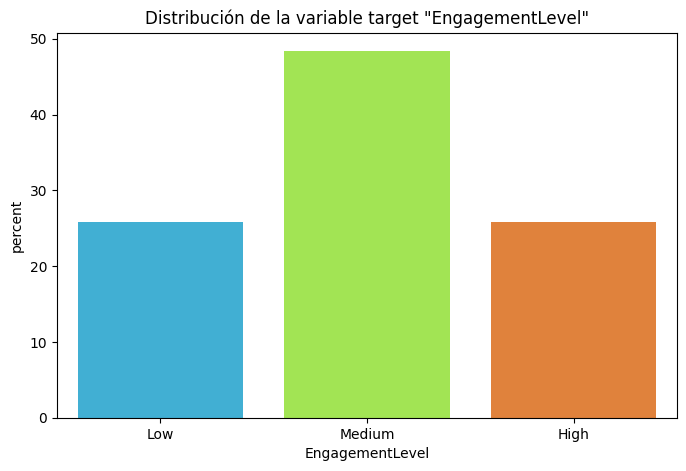

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(train_set, x=target, legend=False, hue=target, stat='percent', palette='turbo')
plt.title('Distribución de la variable target "EngagementLevel"');

#### Visualización de las features:  
A priori podemos observar gráficamente las variables que más varían según su relación con el target. Aunque posteriormente apliquemos métodos para determinar el feature importance, de partida podemos decir que las variables *'SessionsPerWeek','AvgSessionDurationMinutes','PlayerLevel','AchievementsUnlocked'* son las más interesantes.

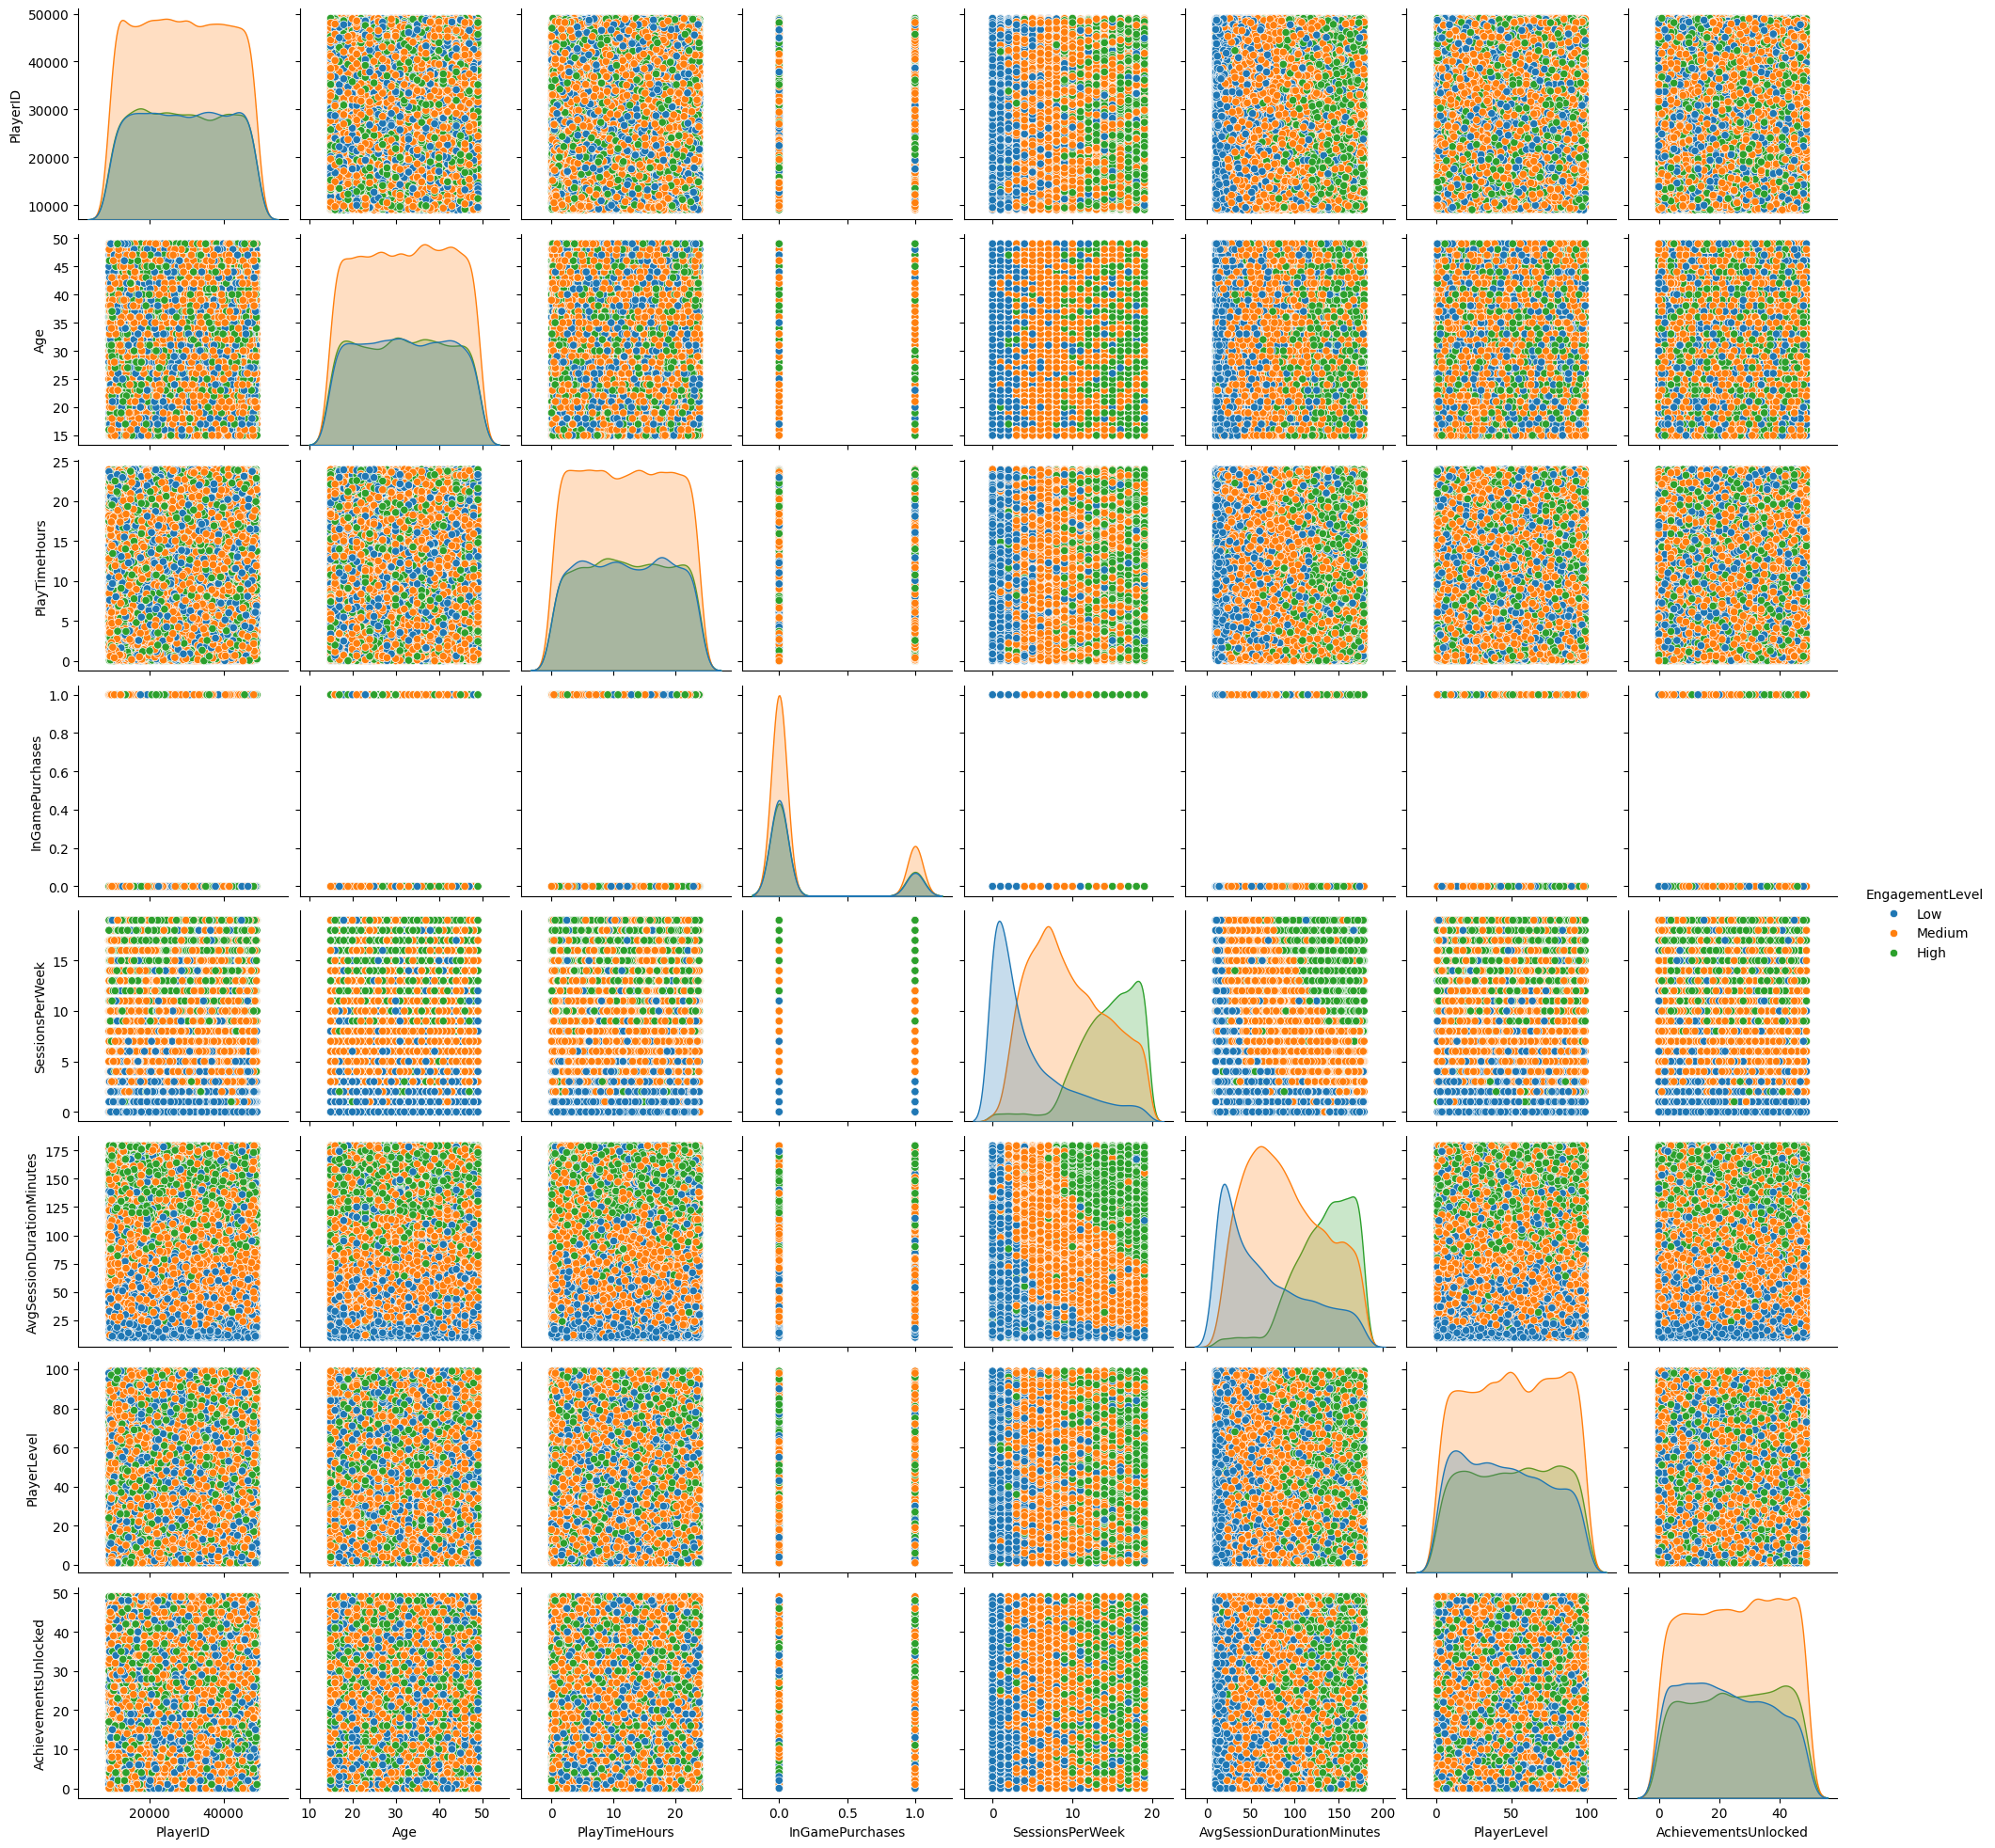

In [ ]:
sns.pairplot(train_set, hue=target, kind='scatter')

Vemos la distribuición de las features numéricas. No se observan outliers, pero si tendremos que aplicar transformaciones para escalar los datos.

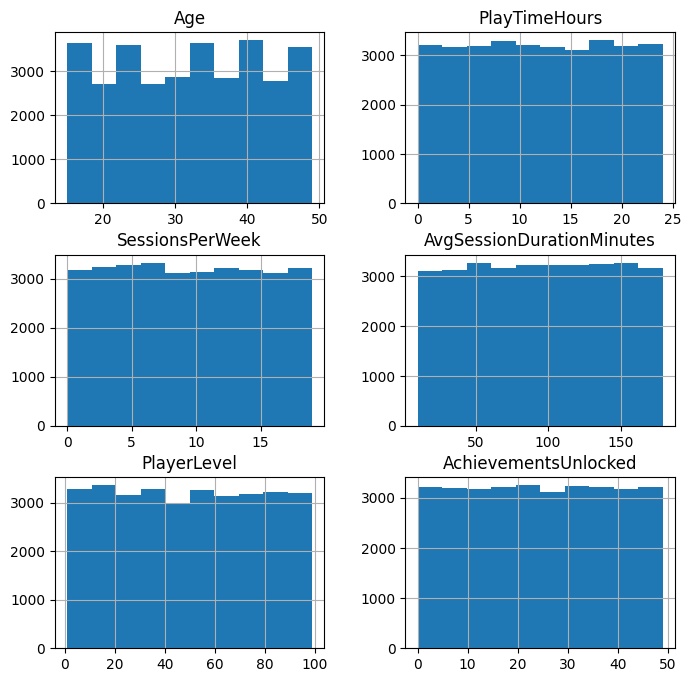

In [ ]:
train_set[num_col].hist(figsize=(8,8));

Vemos en un heatmap las correlaciones entre variables numéricas:

Text(0.5, 1.0, 'Correlación de variables numéricas')

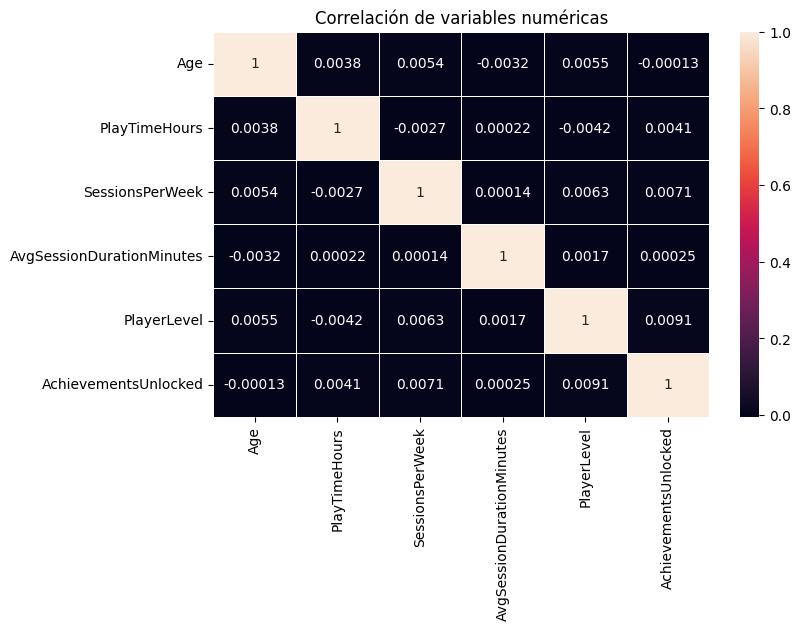

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(train_set[num_col].corr(), annot=True, linewidths=0.5)
plt.title('Correlación de variables numéricas')

Vemos la distribución entre variables categóricas:

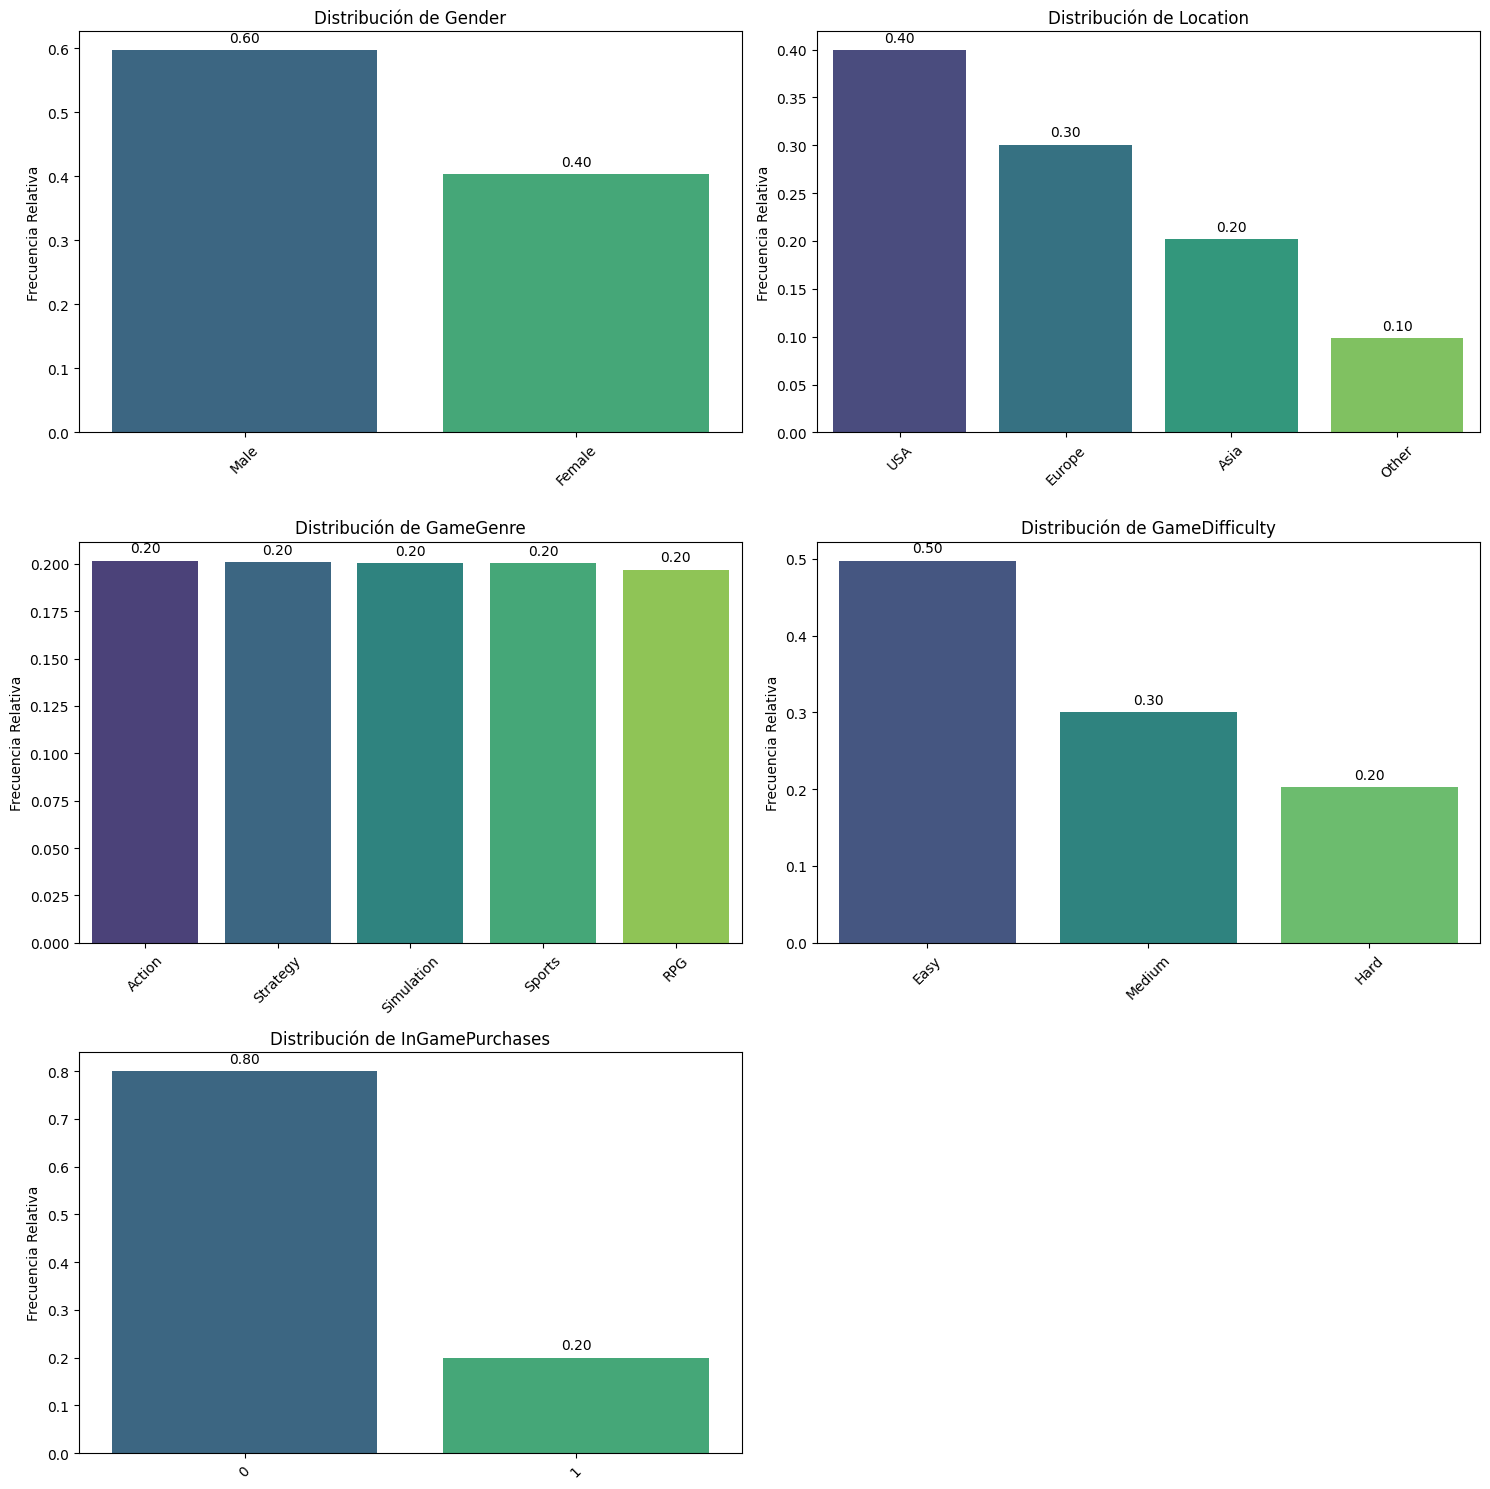

In [ ]:
bt.pinta_distribucion_categoricas(train_set, cat_col, relativa=True, mostrar_valores=True)

In [ ]:
#Observamos la relacion entre compras, nivel de juego y egagament
tabla_contingencia = pd.crosstab([data.GameDifficulty, data.InGamePurchases], data[target])
tabla_contingencia

EngagementLevel                 High   Low  Medium
GameDifficulty InGamePurchases                    
Easy           0                4095  4185    7740
               1                1037  1021    1937
Hard           0                1669  1678    3060
               1                 443   398     760
Medium         0                2438  2424    4704
               1                 654   618    1173

## **Tratamiento de features**

#### 1. Justificación y tratamiento de variables numéricas

``` 'PlayerID' ```  
Empezaremos por borrar la variable en train y test, ya que por su alta cardinalidad y funcionar como índice no nos aportará mucha información a la hora de realizar predicciones.

In [16]:
#Instanciamos una copia de los sets por si tenemos que enmendar cualquier error.
train_set_bck = train_set.copy()
test_set_bck = test_set.copy()

In [7]:
train_set.drop(['PlayerID'], axis=1, inplace=True)
test_set.drop(['PlayerID'], axis=1, inplace=True)

```Age```, ``` PlayerLevel``` y ```AchievementsUnlocked```  
Son variables continuas que bien podrían tratarse como categóricas si las agrupamos en intervalos. Por ejemplo, grupos de edad (menores de 20, etc) o niveles de jugador (alto, medio, bajo). En nuestro caso a priori, no las trateremos y probaremos a entrenar el modelo dejándolas tal cual porque los valores parecen estar bien distribuidos.  

```SessionsPerWeek``` y ```AvgSessionsDurationMinutes```  
Son variables que visualmente promenten ya que son las que más variabilidad presentan en función del target.  

```PlaytimeHours```  
Puede ser interesante aunque gráficamente no presente mucha variabilidad según el target.

Procesaremos todas las variables más adelante en un pipeline.

In [18]:
train_set[num_col].describe()

Age  PlayTimeHours  SessionsPerWeek  \
count  32027.000000   32027.000000     32027.000000   
mean      32.018172      12.017122         9.460143   
std       10.044937       6.917953         5.764904   
min       15.000000       0.000630         0.000000   
25%       23.000000       6.049973         4.000000   
50%       32.000000      11.983743         9.000000   
75%       41.000000      17.960718        14.000000   
max       49.000000      23.999592        19.000000   

       AvgSessionDurationMinutes   PlayerLevel  AchievementsUnlocked  
count               32027.000000  32027.000000          32027.000000  
mean                   94.941674     49.706154             24.509258  
std                    48.898390     28.595931             14.436342  
min                    10.000000      1.000000              0.000000  
25%                    53.000000     25.000000             12.000000  
50%                    95.000000     49.000000             24.000000  
75%                   137.000000     74.000000             37.000000  
max                   179.000000     99.000000             49.000000

#### 2. Justificación y tratamiento de variables categóricas  
Dado que todas nuestras variables categóricas no tienen más de 5 clases, recurriremos a un **OneHotEncoder** mediante el uso de un **pipeline** para codificarlas.  
Generaremos dos pipelines de preprocesado:  
- ```preprocessing```: aplicaremos **MinMaxScaler()** para normalizar las variables numéricas y un **OneHotEncoder** para codificar las variables categóricas.  
- ```preproc_cat```: sin emplear **OneHotEncoder** en las variables categóricas para utilizarlas con un **CatBoostClassifier** y comparar resultados con otros modelos.

## **Preprocesado**  
Dado que según el histograma, las variables numéricas siguen una distribución uniforme y no hay presencia de valores atípicos, escalaremos las variables numéricas apoyándonos en un **MinMaxScaler()**

In [8]:
X_train = train_set.drop([target], axis=1)
X_test = test_set.drop([target], axis=1)

y_train = train_set[target]
y_test = test_set[target]

In [9]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32027, 11) (8007, 11)
(32027,) (8007,)


In [21]:
X_train.head() #vemos como queda nuestro X_train

Age  Gender Location   GameGenre  PlayTimeHours  InGamePurchases  \
13686   45    Male   Europe    Strategy      15.479460                1   
37598   24  Female   Europe    Strategy      16.402266                0   
37339   45    Male      USA  Simulation      19.920505                1   
6804    34  Female   Europe         RPG       3.392229                0   
5674    43    Male     Asia    Strategy       9.036937                0   

      GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
13686           Easy               10                        108           86   
37598           Easy                5                         77           56   
37339         Medium                6                         36            4   
6804            Easy                4                         50           10   
5674            Easy               13                         23           59   

       AchievementsUnlocked  
13686                    19  
37598                    23  
37339                    23  
6804                      0  
5674                     22

In [22]:
print(y_train.head()) #vemos como queda y_train
print(type(y_train))

13686       Low
37598    Medium
37339       Low
6804        Low
5674     Medium
Name: EngagementLevel, dtype: object
<class 'pandas.core.series.Series'>


In [10]:
#mapearemos 'y' para entrenar
labels = {'Low':0,
          'Medium': 1,
          'High': 2}
y_train_encoded = y_train.map(labels)
y_train_encoded.head()

13686    0
37598    1
37339    0
6804     0
5674     1
Name: EngagementLevel, dtype: int64

In [11]:
#Quitamos de la lista de columnas categóricas la variable 'InGamePurchases' ya que está codificada y no queremos pasarla para el OneHotEnconder
cat_col.remove('InGamePurchases')

print('Lista de variables numéricas para preprocesado:', num_col)
print('-'*20)
print('Lista de variables categóricas para preprocesado:', cat_col)

Lista de variables numéricas para preprocesado: ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']
--------------------
Lista de variables categóricas para preprocesado: ['Gender', 'Location', 'GameGenre', 'GameDifficulty']


In [12]:
#Preprocessing
num_pipe = Pipeline([
    ('mmscaler', MinMaxScaler())
])

cat_pipe = Pipeline([
    ('one_hot', OneHotEncoder(sparse_output=False)) #para que no delvuelva los datos en forma de matriz
])

preprocessing = ColumnTransformer([
    ('normalize', num_pipe, num_col),
    ('encode', cat_pipe, cat_col)
], remainder='passthrough'
).set_output(transform= 'pandas') #para que devuelva los resultados del preprocesado en un dataframe y no en un array

In [13]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('normalize',
                                 Pipeline(steps=[('mmscaler', MinMaxScaler())]),
                                 ['Age', 'PlayTimeHours', 'SessionsPerWeek',
                                  'AvgSessionDurationMinutes', 'PlayerLevel',
                                  'AchievementsUnlocked']),
                                ('encode',
                                 Pipeline(steps=[('one_hot',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Gender', 'Location', 'GameGenre',
                                  'GameDifficulty'])])

In [13]:
#visualizamos el resultado
X_train_prep = preprocessing.fit_transform(X_train)
X_train_prep.head(3)

normalize__Age  normalize__PlayTimeHours  normalize__SessionsPerWeek  \
13686        0.882353                  0.644979                    0.526316   
37598        0.264706                  0.683431                    0.263158   
37339        0.882353                  0.830031                    0.315789   

       normalize__AvgSessionDurationMinutes  normalize__PlayerLevel  \
13686                              0.579882                0.867347   
37598                              0.396450                0.561224   
37339                              0.153846                0.030612   

       normalize__AchievementsUnlocked  encode__Gender_Female  \
13686                         0.387755                    0.0   
37598                         0.469388                    1.0   
37339                         0.469388                    0.0   

       encode__Gender_Male  encode__Location_Asia  encode__Location_Europe  \
13686                  1.0                    0.0                      1.0   
37598                  0.0                    0.0                      1.0   
37339                  1.0                    0.0                      0.0   

       ...  encode__Location_USA  encode__GameGenre_Action  \
13686  ...                   0.0                       0.0   
37598  ...                   0.0                       0.0   
37339  ...                   1.0                       0.0   

       encode__GameGenre_RPG  encode__GameGenre_Simulation  \
13686                    0.0                           0.0   
37598                    0.0                           0.0   
37339                    0.0                           1.0   

       encode__GameGenre_Sports  encode__GameGenre_Strategy  \
13686                       0.0                         1.0   
37598                       0.0                         1.0   
37339                       0.0                         0.0   

       encode__GameDifficulty_Easy  encode__GameDifficulty_Hard  \
13686                          1.0                          0.0   
37598                          1.0                          0.0   
37339                          0.0                          0.0   

       encode__GameDifficulty_Medium  remainder__InGamePurchases  
13686                            0.0                           1  
37598                            0.0                           0  
37339                            1.0                           1  

[3 rows x 21 columns]

In [14]:
#preproc_cat, preprocesado para CatBoostClassifier
num_pipe = Pipeline([
    ('mmscaler', MinMaxScaler())
])

preproc_catboost = ColumnTransformer([
    ('normalize', num_pipe, num_col),
], remainder='passthrough'
).set_output(transform= 'pandas') #para que devuelva los resultados del preprocesado en un dataframe y no en un array

In [16]:
preproc_catboost

ColumnTransformer(remainder='passthrough',
                  transformers=[('normalize',
                                 Pipeline(steps=[('mmscaler', MinMaxScaler())]),
                                 ['Age', 'PlayTimeHours', 'SessionsPerWeek',
                                  'AvgSessionDurationMinutes', 'PlayerLevel',
                                  'AchievementsUnlocked'])])

In [15]:
#visualizamos el resultado
X_train_cat = preproc_catboost.fit_transform(X_train)
X_train_cat.head(3)

normalize__Age  normalize__PlayTimeHours  normalize__SessionsPerWeek  \
13686        0.882353                  0.644979                    0.526316   
37598        0.264706                  0.683431                    0.263158   
37339        0.882353                  0.830031                    0.315789   

       normalize__AvgSessionDurationMinutes  normalize__PlayerLevel  \
13686                              0.579882                0.867347   
37598                              0.396450                0.561224   
37339                              0.153846                0.030612   

       normalize__AchievementsUnlocked remainder__Gender remainder__Location  \
13686                         0.387755              Male              Europe   
37598                         0.469388            Female              Europe   
37339                         0.469388              Male                 USA   

      remainder__GameGenre  remainder__InGamePurchases  \
13686             Strategy                           1   
37598             Strategy                           0   
37339           Simulation                           1   

      remainder__GameDifficulty  
13686                      Easy  
37598                      Easy  
37339                    Medium

In [16]:
#seleccionamos los nuevos nombres de columnascategóricas generados tras el preprocesado de ColumnTransformed y lo convertimos a tipo category para el Catboost
cat_col_preprocessed = X_train_cat.select_dtypes('object')
cat_col_preprocessed = cat_col_preprocessed.astype('category')
cat_col_preprocessed= cat_col_preprocessed.columns.to_list()
cat_col_preprocessed

['remainder__Gender',
 'remainder__Location',
 'remainder__GameGenre',
 'remainder__GameDifficulty']

In [18]:
#guardamos ambos dataframes como csv en ./data/processed
X_train_prep.to_csv('general_data_preprocessed.csv', index=False)
X_train_cat.to_csv('data_for_catboost.csv', index=False)

## **Baseline**
Compararemos varios modelos de clasificación supervisada apoyándonos en ```cross_validate``` ya que queremos medir también los tiempos de entrenamiento y obtener tanto métricas de entrenamiento como posibles métricas de validación.

Por otro lado, usaremos ```stratifiedKFold``` para que mantenga la proporcion de clases en la validación, ya que tenemos una clase bastante superior en número de muestras comparado con el resto.

In [17]:
#Instanciamos un diccionario con todos los pipelines de modelos para poder iterar sobre ellos y sacar los scores de cada uno de ellos.
pipe_dict = {
'DecisionTreeClas' : Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', DecisionTreeClassifier(random_state=42))
]),

'LogisticRegression' : Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', LogisticRegression(random_state=42))
]),

'RandomForestClas' : Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', RandomForestClassifier(random_state=42))
]),

'XGBClassfier': Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', XGBClassifier(random_state=42))
]),

'LGBMClassifier' : Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', LGBMClassifier(random_state=42)),
]),

'KNN' : Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', KNeighborsClassifier()),
]),

'CatBoostClas' : Pipeline([
   ('preprocessing_cat', preproc_catboost), #aquí entrenaremos con los datos preprocesados especificamente para el Catboost
    ('modelo', CatBoostClassifier(random_state=42, cat_features=cat_col_preprocessed))]) #especificamos cuáles son las columnas categóricas para que las identifique y las trate
}


In [35]:
pipe_dict.keys()

dict_keys(['DecisionTreeClas', 'LogisticRegression', 'RandomForestClas', 'XGBClassfier', 'LGBMClassifier', 'KNN', 'CatBoostClas'])

In [18]:
#Instanciamos los KFolds para las clases desbalanceadas:
stratified_kfold = StratifiedKFold() #dejamos todos los parámetros por defecto. En este caso hará 5 batches

In [37]:
resultados_cv = []

for clave, pipe in pipe_dict.items():
    cross_validate_resultados = cross_validate(pipe, X_train, y_train_encoded, cv=stratified_kfold,
                                               scoring='balanced_accuracy', n_jobs=-1, return_train_score=True)

    resultados_cv.append({'modelo' : clave,
                      'fit_time': np.mean(cross_validate_resultados['fit_time']),
                      'score_time': np.mean(cross_validate_resultados['score_time']),
                      'train_score': np.mean(cross_validate_resultados['train_score']),
                      'val_score' : np.mean(cross_validate_resultados['test_score'])})

df_resultados_cv = pd.DataFrame(resultados_cv).set_index('modelo')
df_resultados_cv

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


fit_time  score_time  train_score  val_score
modelo                                                            
DecisionTreeClas      0.355366    0.024521     1.000000   0.823667
LogisticRegression    0.320406    0.023661     0.806924   0.805952
RandomForestClas      5.705017    0.218085     0.999995   0.881759
XGBClassfier          2.390496    0.096258     0.946081   0.902707
LGBMClassifier        1.502725    0.179147     0.922507   0.906398
KNN                   0.091034    2.390581     0.775761   0.644428
CatBoostClas        118.217505    0.119345     0.921107   0.906698

In [ ]:
#guardamos los resultados para no depender de ejecutar la celda posteriormente
df_resultados_cv.to_csv('df_resultados_cv.csv', index=True, header=True)

### **Curvas de aprendizaje**

In [19]:
## Definimos una función para pintar la curva de aprendizaje de cada modelo que hemos instanciado como baseline
def plot_learning_curve (model, X_train, y_train, cv, scoring):
    train_sizes, train_score, test_score = learning_curve(model, X_train, y_train, train_sizes= np.linspace(0.1, 1.0, 5), cv=cv, scoring=scoring, n_jobs=-1)
    display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_score, test_scores=test_score)
    display.plot()
    plt.title(f'Curva de aprendizaje para {model.__class__.__name__}')
    plt.xlabel('Train sizes')
    plt.ylabel(f'Score:{scoring}')
    plt.show()

**DecisionTreeClassfier**  
La puntuación de train se mantiene constante desde el inicio, comprobamos que el modelo tiende al overfitting si no aplicamos ningún tipo de penalización o límitación al modelo.

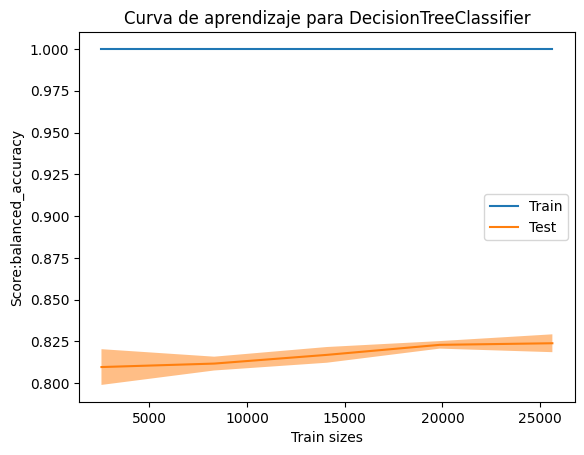

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
scoring = 'balanced_accuracy'

plot_learning_curve(decision_tree, X_train_prep, y_train_encoded, stratified_kfold, scoring)

**RandomForestClassifier**  
Al igual que DecisionTree tiende al overfitting si no aplicamos ningún tipo de  límitación al modelo.

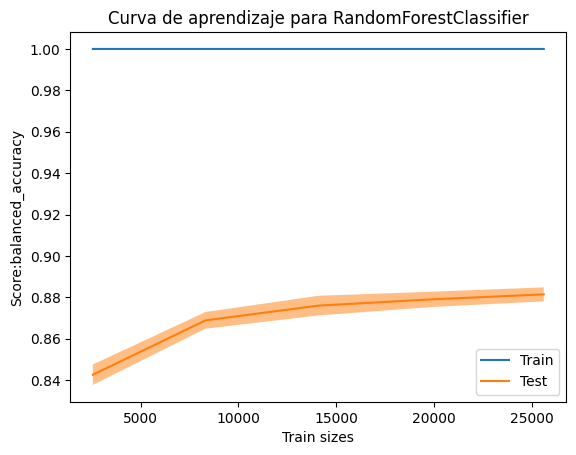

In [ ]:
random_forest = RandomForestClassifier(random_state=42)
plot_learning_curve(random_forest, X_train_prep, y_train_encoded, stratified_kfold, scoring)

**XGBClassifier**  
La puntuación de train desciende lentamente a medida que aumenta el número de muestras con el que trabaja, sin embargo no llega a acercarse demasiado a la curva de validación. Aunque existe poca diferencia entre las puntuaciones de train y test, la caida de train con respecto el aumento del número de muestras debería ser algo más inmediata.   
Es posible que con más datos la curva mejore.

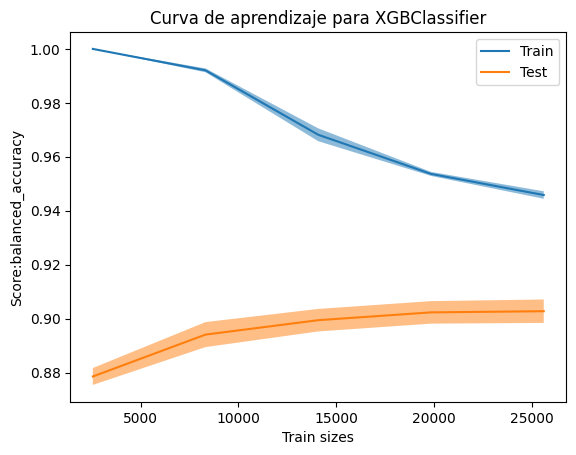

In [ ]:
xgb = XGBClassifier(random_state=42)
plot_learning_curve(xgb, X_train_prep, y_train_encoded, stratified_kfold, scoring)

**LGBMClassifier**  
En este modelo si podemos observar como la curva de train cae drásticamente a medida que aumenta el número de muestras. La curva de validación, al igual que en el modelo anterior tiende a estabilizarse, sería interesante ver cómo se comporta con más datos. Sin embargo, este modelo apunta a ser el que mejor generalice.

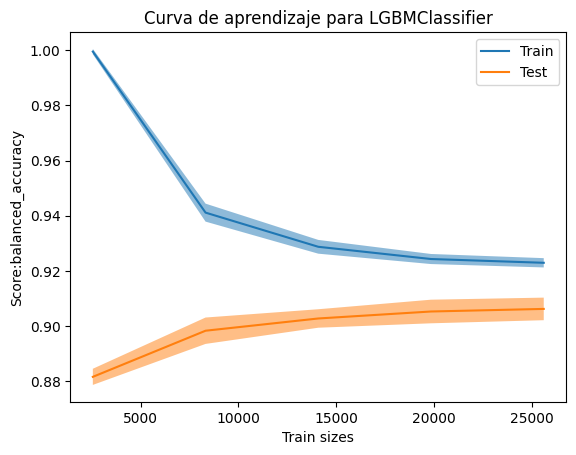

In [ ]:
lgbm = LGBMClassifier(random_state=42)
plot_learning_curve(lgbm, X_train_prep, y_train_encoded, stratified_kfold, scoring)

**CatBoostClassifier**  
También parece que tiene una buena capacidad de aprendizaje, incluso los datos de validación son mejores que en el resto de modelos aunque presenta mayor variabilidad si nos fijamos en la zona sombreada.

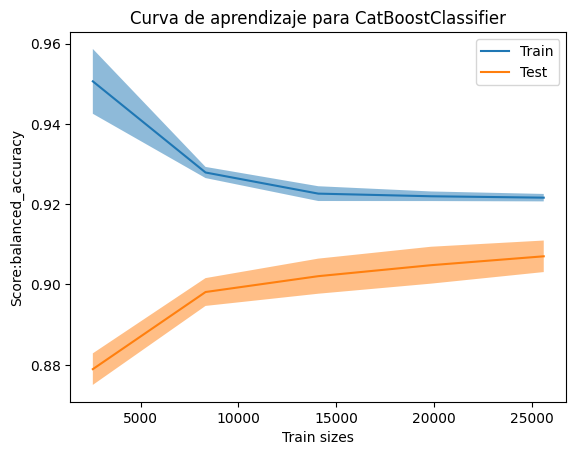

In [ ]:
catboost = CatBoostClassifier(random_state=42, cat_features=cat_col_preprocessed)
scoring = 'balanced_accuracy'

plot_learning_curve(catboost, X_train_cat, y_train_encoded, stratified_kfold, scoring)

**LogisticRegression**  
Lo que más llama la atención de la gráfica es la gran variabilidad que presenta en cada curva, puede ser por varias razones pero apuntaremos a que es un modelo más simple y puede que este recibiendo algo de ruido.

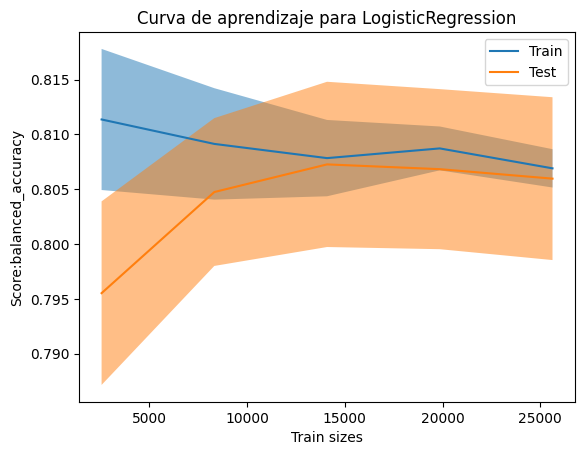

In [ ]:
logisticreg = LogisticRegression(random_state=42)
plot_learning_curve(logisticreg, X_train_prep, y_train_encoded, stratified_kfold, scoring)

**KNN**  
Al contrario que los modelos anteriores, el aumento del score en train y en validación es proporcional al número de muestras que recibe.

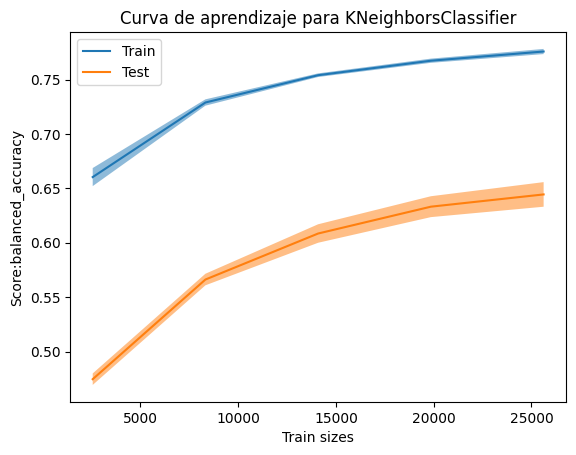

In [ ]:
knn = KNeighborsClassifier()
plot_learning_curve(knn, X_train_prep, y_train_encoded, stratified_kfold, scoring)

### **Selección de modelos para optimizado**

- **LGBMClassifier**: Como mejor modelo resultado de la validación y menor tiempo de entrenamiento, probaremos a optimizar hiperparámetros con GridSearch y seleccionar las features más relevantes para entrenarlo y compararlo con su baseline.
- **LogisticRegression** : Probaremos a aplicar penalizaciones y a restringir el número de features en el entrenamiento para comprobar si mejora con respecto al baseline.
- **RandomForestClassifier**: Probaremos a limitar el modelo y a aplicar penalizaciones para comprobar si podemos evitar el overfitting con este modelo y comparar resultados con el resto de modelos seleccionados.

El objetivo final será comprobar qué modelo da mejores resultados con menor tiempo de ejecución.

## **Modelado**

### **LGBMClassifier**

### **Feature Importance**
Emplearemos el método propio del modelo escogido para la selección de features.



In [20]:
#Mantenemos el preprocesado para que esté en igualdad de condiciones con el baseline
lgbm = Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', LGBMClassifier(random_state=42, class_weight='balanced', verbose=-100))]) #añadimos class_weight para balancear las clases al entrenar

lgbm.fit(X_train, y_train_encoded)

df_features_importance_lgbm = pd.DataFrame(lgbm[1].feature_importances_, columns= ['importance']).set_index(X_train_prep.columns) #Accedemos al segundo elemento del pipeline
df_features_importance_lgbm = df_features_importance_lgbm.sort_values(by= 'importance', ascending=False)
df_features_importance_lgbm


importance
normalize__AvgSessionDurationMinutes        2023
normalize__SessionsPerWeek                  1515
normalize__PlayerLevel                      1456
normalize__AchievementsUnlocked             1305
normalize__PlayTimeHours                    1059
normalize__Age                               670
encode__GameDifficulty_Easy                  116
encode__Location_USA                          91
encode__GameGenre_Simulation                  74
encode__GameDifficulty_Medium                 72
remainder__InGamePurchases                    72
encode__Location_Europe                       71
encode__GameDifficulty_Hard                   70
encode__GameGenre_Sports                      65
encode__GameGenre_RPG                         63
encode__Gender_Female                         55
encode__Location_Asia                         52
encode__GameGenre_Strategy                    52
encode__GameGenre_Action                      51
encode__Location_Other                        38
encode__Gender_Male                           30

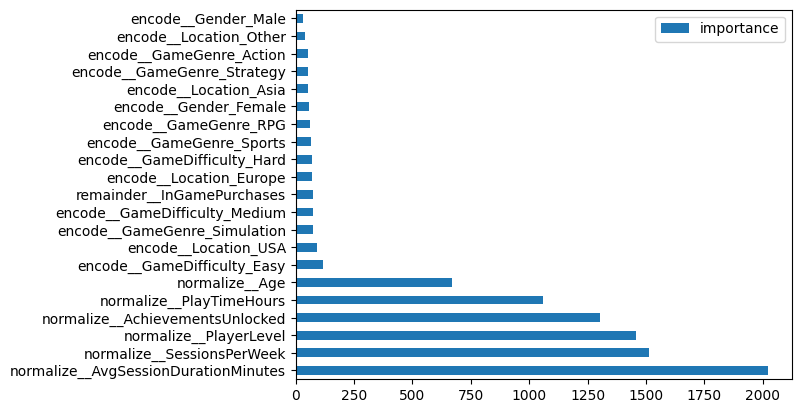

In [ ]:
df_features_importance_lgbm.plot(kind='barh');

In [21]:
features_selected = df_features_importance_lgbm.iloc[:6]
features_selected = features_selected.index.to_list()
features_selected

['normalize__AvgSessionDurationMinutes',
 'normalize__SessionsPerWeek',
 'normalize__PlayerLevel',
 'normalize__AchievementsUnlocked',
 'normalize__PlayTimeHours',
 'normalize__Age']

Parece que las variables numéricas son las que mayor importancia reciben según el modelo. Crearemos una lista con las features numéricas en este caso para entrenar el modelo y comparar con el baseline.

### **Optimización de hiperparámetros y entrenamiento**  

Combinaremos la librería **imbalaced learn**  y **StrarifiedKFold** para balancear las clases minoritarias.   
Crearemos un pipeline para el entrenamiento y optimización apoyándonos en un **GridSearch**.

In [ ]:
model_pipe = ImbPipeline([ #no le ponemos preprocesado porque entrenaremos con X_train_prep para poder filtrar por las columnas seleccionadas por el feature importance
                          ('sampling', None), #aquí emplearemos el GridSearch para determinar cuál será el mejor método de muestreo
                          ('modelo', LGBMClassifier(random_state=42, verbose=-100))
                          ])

param_grid = {
    'sampling' : [RandomOverSampler(random_state=42), None],
    'modelo__num_leaves': [20, 30, 40],
    'modelo__learning_rate': [0.05, 0.1],
    'modelo__n_estimators': [50, 100],
    'modelo__max_depth': [-1, 10, 20],
    'modelo__min_child_samples': [10, 15, 25],
    'modelo__subsample': [0.7, 0.8],
    'modelo__class_weight': ['balanced', None] #Para tener alternativas con el sampling
}

In [ ]:
grid_search = GridSearchCV(model_pipe, param_grid=param_grid, scoring='balanced_accuracy', cv=stratified_kfold, n_jobs=-1)
grid_search.fit(X_train_prep[features_selected], y_train_encoded)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling', None),
                                       ('modelo',
                                        LGBMClassifier(random_state=42,
                                                       verbose=-100))]),
             n_jobs=-1,
             param_grid={'modelo__class_weight': ['balanced', None],
                         'modelo__learning_rate': [0.05, 0.1],
                         'modelo__max_depth': [-1, 10, 20],
                         'modelo__min_child_samples': [10, 15, 25],
                         'modelo__n_estimators': [50, 100],
                         'modelo__num_leaves': [20, 30, 40],
                         'modelo__subsample': [0.7, 0.8],
                         'sampling': [RandomOverSampler(random_state=42),
                                      None]},
             scoring='balanced_accuracy')

In [ ]:
print('Mejores parámetros:', grid_search.best_params_)
print('Mejor score:', grid_search.best_score_)

Mejores parámetros: {'modelo__class_weight': 'balanced', 'modelo__learning_rate': 0.1, 'modelo__max_depth': 20, 'modelo__min_child_samples': 10, 'modelo__n_estimators': 100, 'modelo__num_leaves': 40, 'modelo__subsample': 0.7, 'sampling': None}
Mejor score: 0.9091545269354772


Guardamos el modelo entrenado:

In [ ]:
with open('Modelo_LGBMClassifier_None', 'wb') as file:
    pickle.dump(grid_search, file)

In [108]:
with open('./model/Modelo_LGBMClassifier_None', 'rb') as file:
    unpickle_model_lgbm = pickle.load(file)

In [ ]:
unpickle_model_lgbm

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling', None),
                                       ('modelo',
                                        LGBMClassifier(random_state=42,
                                                       verbose=-100))]),
             n_jobs=-1,
             param_grid={'modelo__class_weight': ['balanced', None],
                         'modelo__learning_rate': [0.05, 0.1],
                         'modelo__max_depth': [-1, 10, 20],
                         'modelo__min_child_samples': [10, 15, 25],
                         'modelo__n_estimators': [50, 100],
                         'modelo__num_leaves': [20, 30, 40],
                         'modelo__subsample': [0.7, 0.8],
                         'sampling': [RandomOverSampler(random_state=42),
                                      None]},
             scoring='balanced_accuracy')

In [109]:
#vamos a registrar el tiempo de entrenamiento para luego compararlo con el resto de modelos
inicio = time()
unpickle_model_lgbm.best_estimator_.fit(X_train_prep[features_selected], y_train_encoded)
tiempo_lgbm = time() - inicio

In [110]:
tiempo_lgbm

0.544503927230835

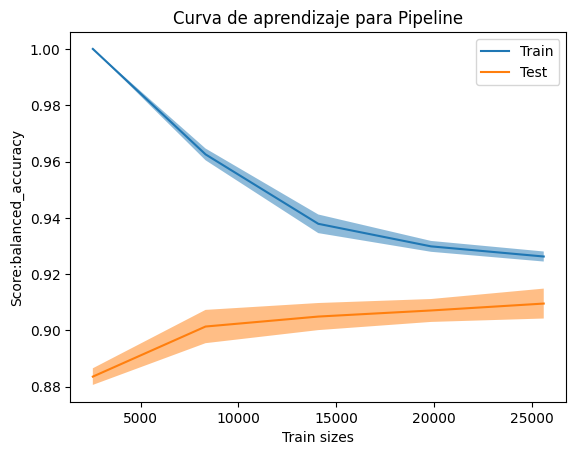

In [74]:
plot_learning_curve(unpickle_model_lgbm.best_estimator_, X_train_prep[features_selected], y_train_encoded, cv=stratified_kfold, scoring=scoring)

### **Evaluación contra test**

In [ ]:
#Aplicamos el mismo procesado a X_test para la predicción
X_test_prep = preprocessing.transform(X_test)

In [ ]:
#mapearemos también 'y_test' para la prediccion
labels = {'Low':0,
          'Medium': 1,
          'High': 2}
y_test_encoded = y_test.map(labels)
y_test_encoded.head()

33212    2
32450    2
25718    2
25647    1
6697     1
Name: EngagementLevel, dtype: int64

In [ ]:
y_pred_lgbm= unpickle_model_lgbm.predict(X_test_prep[features_selected]) #hacemos la predicción con la selección de features con la que hemos entrenado
prediccion = balanced_accuracy_score(y_test_encoded, y_pred_lgbm)
test_score = classification_report(y_test_encoded, y_pred_lgbm)

print('Balanced Accuracy Score =', prediccion)
print('Predicciones:')
print(classification_report(y_test_encoded, y_pred_lgbm))


Balanced Accuracy Score = 0.9060880464349522
Predicciones:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2065
           1       0.92      0.93      0.93      3875
           2       0.90      0.89      0.90      2067

    accuracy                           0.91      8007
   macro avg       0.91      0.91      0.91      8007
weighted avg       0.91      0.91      0.91      8007



In [ ]:
#para volver a ver las etiquetas de cada clase usaremos el parámetro target_names de classification report:
clases = ['Low', 'Medium', 'High'] #como son pocas podemos instanciarlas munualmente

In [ ]:
print(classification_report(y_test_encoded, y_pred_lgbm, target_names=clases))

              precision    recall  f1-score   support

         Low       0.89      0.91      0.90      2065
      Medium       0.92      0.93      0.93      3875
        High       0.90      0.89      0.90      2067

    accuracy                           0.91      8007
   macro avg       0.91      0.91      0.91      8007
weighted avg       0.91      0.91      0.91      8007



#### Matriz de confusión

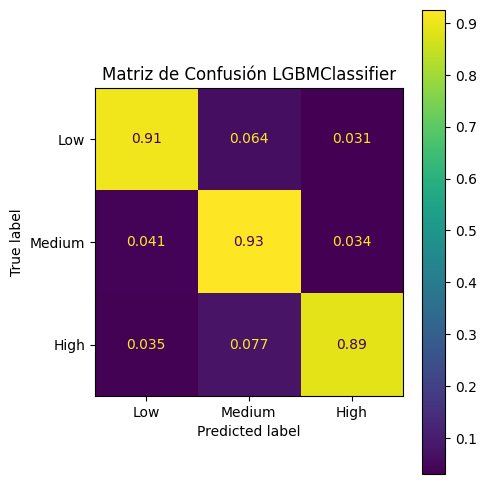

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_lgbm, normalize= 'true', ax=ax)
plt.title('Matriz de Confusión LGBMClassifier')
plt.xticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.yticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.tight_layout()
plt.show()

**Conclusiones**  
El score de train parece que baja ligeramente tras aplicar reducción de features y optimizar los hiperparámetros pero no de forma significativa. Los resultados de test se mantienen constantes. La curva de aprendizaje no parece mejorar con respecto a la del baseline y aunque no se ve un overfitting muy pronunciado, puede que el modelo no generalize del todo bien. Veremos a continuación si podemos afinarlo un poco más. 

En la matriz de confusión observamos que presenta una alta probabilidad de acierto en cada clase, compararemos esta matriz con la resultante de la optimización.

### **Optimización para posible Overfitting en LGBMClassifier**

In [ ]:
model_pipe_lgbm_control = Pipeline([   ('preprocesado', preprocessing), #entrenaremos con todas las features
                          ('modelo', LGBMClassifier(random_state=42, verbose=-100))
                          ])

param_grid_bis = {
    'modelo__num_leaves': [10, 20], #Reducción de hojas por árbol
    'modelo__learning_rate': [0.05, 0.1],
    'modelo__n_estimators': [20, 50, 80], #reducimos numero de árboles
    'modelo__max_depth': [1, 3, 5],
    'modelo__min_child_samples': [10, 15, 25],
    'modelo__subsample': [0.7, 0.8],
    'modelo__reg_alpha' :[0., 0.01, 0.1], #incluimos regularización L1
    #'modelo_reg_lambda' : [0., 0.01, 0.1], #regularización L2
    'modelo__class_weight': ['balanced', None]}

In [96]:
grid_search_lgbm_control = GridSearchCV(model_pipe_lgbm_control, param_grid=param_grid_bis, scoring='balanced_accuracy', cv=stratified_kfold, n_jobs=-1)
grid_search_lgbm_control.fit(X_train, y_train_encoded)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('normalize',
                                                                         Pipeline(steps=[('mmscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'PlayTimeHours',
                                                                          'SessionsPerWeek',
                                                                          'AvgSessionDurationMinutes',
                                                                          'PlayerLevel',
                                                                          'AchievementsUnlocked']),
                                                                        ('encode'...
                                        LGBMClassifier(random_state=42,
                                                       verbose=-100))]),
             n_jobs=-1,
             param_grid={'modelo__class_weight': ['balanced', None],
                         'modelo__learning_rate': [0.05, 0.1],
                         'modelo__max_depth': [1, 3, 5],
                         'modelo__min_child_samples': [10, 15, 25],
                         'modelo__n_estimators': [20, 50, 80],
                         'modelo__num_leaves': [10, 20],
                         'modelo__reg_alpha': [0.0, 0.01, 0.1],
                         'modelo__subsample': [0.7, 0.8]},
             scoring='balanced_accuracy')

In [102]:
with open('./model/Modelo_LGBMClassifier_Controled', 'wb') as file:
    pickle.dump(grid_search_lgbm_control, file)

In [101]:
print('Mejores parámetros:', grid_search_lgbm_control.best_params_)
print('Mejor score:', grid_search_lgbm_control.best_score_)

Mejores parámetros: {'modelo__class_weight': 'balanced', 'modelo__learning_rate': 0.1, 'modelo__max_depth': 5, 'modelo__min_child_samples': 15, 'modelo__n_estimators': 80, 'modelo__num_leaves': 20, 'modelo__reg_alpha': 0.0, 'modelo__subsample': 0.7}
Mejor score: 0.9038294178653613


In [106]:
inicio = time()
grid_search_lgbm_control.best_estimator_.fit(X_train, y_train_encoded)
tiempo_lgbm_c = time() - inicio
tiempo_lgbm_c

0.3987593650817871

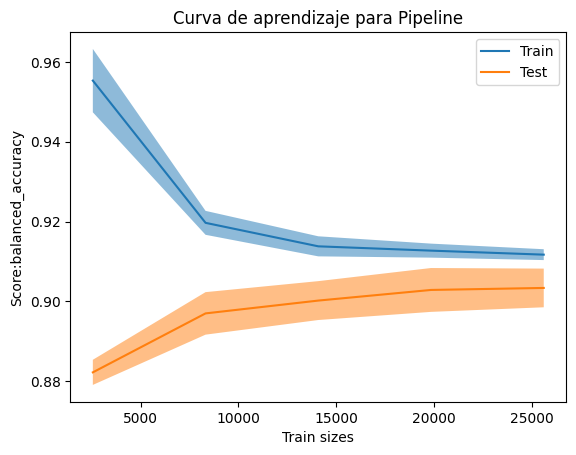

In [100]:
scoring='balanced_accuracy'
plot_learning_curve(grid_search_lgbm_control.best_estimator_, X_train, y_train_encoded, cv=stratified_kfold, scoring=scoring)

### **Evaluación contra test: modelo optimizado**

In [103]:
y_pred_lgbm_control = grid_search_lgbm_control.predict(X_test) #hacemos la predicción con la selección de features con la que hemos entrenado
prediccion_2 = balanced_accuracy_score(y_test_encoded, y_pred_lgbm_control)
test_score = classification_report(y_test_encoded, y_pred_lgbm_control)

print('Balanced Accuracy Score =', prediccion_2)
print('Predicciones:')
print(classification_report(y_test_encoded, y_pred_lgbm_control, target_names=clases))

Balanced Accuracy Score = 0.898335384147324
Predicciones:
              precision    recall  f1-score   support

         Low       0.87      0.90      0.89      2065
      Medium       0.92      0.91      0.91      3875
        High       0.89      0.88      0.89      2067

    accuracy                           0.90      8007
   macro avg       0.89      0.90      0.90      8007
weighted avg       0.90      0.90      0.90      8007



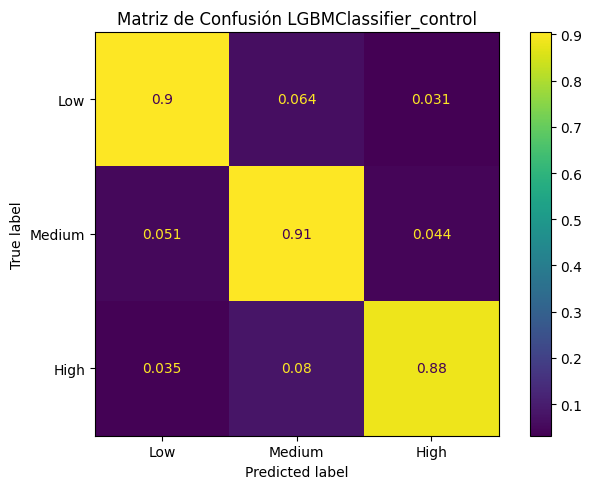

In [105]:
fig, ax = plt.subplots(figsize=(7,5))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_lgbm_control, normalize= 'true', ax=ax)
plt.title('Matriz de Confusión LGBMClassifier_control')
plt.xticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.yticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.tight_layout()
plt.show()

##### **Conclusiones sobre la optimización del modelo y posibilidad de sobreajuste**
Viendo la curva de aprendizaje del modelo optimizado, comprobamos que es posible reducir el sobreajuste aplicando regularización y reduciendo tanto la profundidad, como el número de hojas y árboles sin sacrificar en probabilidades de acierto. 
Llama la atención que el modelo tenga mejor rendimiento sin técnicas de sampling y sin recurrir a la reducción de features.

En definitiva y como veremos en la celda siguiente, un modelo con regularización y menor profundidad realiza predicciones con una alta probabilidad de acierto sin tender al sobreajuste.

In [121]:
#Comprobamos con respecto al baseline
train_baseline = df_resultados_cv.loc['LGBMClassifier']['train_score']
train_lgbm = unpickle_model_lgbm.best_score_
train_lgbm_control = grid_search_lgbm_control.best_score_

test_baseline = df_resultados_cv.loc['LGBMClassifier']['val_score']
time_baseline = df_resultados_cv.loc['LGBMClassifier']['fit_time']

df_comp_lgbm = pd.DataFrame({'train_score': [train_baseline, train_lgbm, train_lgbm_control],
                             'fit_time' : [time_baseline, tiempo_lgbm, tiempo_lgbm_c],
              'test_score' : [test_baseline, prediccion, prediccion_2]}, index= ['LGBM_Baseline', 'LGBM_v1', 'LGBM_model'])
df_comp_lgbm

train_score  fit_time  test_score
LGBM_Baseline     0.922507  2.733564    0.906398
LGBM_v1           0.909155  0.544504    0.906088
LGBM_model        0.903829  0.398759    0.898335

## **Comparativa con otros modelos:**
### **1. Regresión Logistica**

#### **Feature Importance**
Recurriremos a los pesos que otorga el modelo a cada feature además de probar la eliminación de features de forma recursiva (RFE) para reducir features que no aporten información al modelo.

In [135]:
logreg_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', LogisticRegression(random_state=42))])

logreg_pipe.fit(X_train, y_train_encoded)

logreg_features = logreg_pipe.named_steps['modelo'].coef_[0]

df_feature_importance_logreg = pd.DataFrame({'Log_Reg_importance': logreg_features,
                                        }).set_index(X_train_prep.columns)

df_feature_importance_logreg = df_feature_importance_logreg.sort_values(by= 'Log_Reg_importance', ascending=False)
df_feature_importance_logreg



Log_Reg_importance
encode__Gender_Male                             1.361798
encode__Gender_Female                           1.359486
encode__GameDifficulty_Hard                     0.921558
encode__GameDifficulty_Easy                     0.901258
encode__GameDifficulty_Medium                   0.898469
encode__Location_Other                          0.702699
encode__Location_Europe                         0.688912
encode__Location_USA                            0.683215
encode__Location_Asia                           0.646459
encode__GameGenre_Strategy                      0.557609
encode__GameGenre_Sports                        0.555077
encode__GameGenre_RPG                           0.548387
encode__GameGenre_Action                        0.530122
encode__GameGenre_Simulation                    0.530089
normalize__Age                                  0.030918
normalize__PlayTimeHours                       -0.045833
remainder__InGamePurchases                     -0.069942
normalize__PlayerLevel                         -0.745475
normalize__AchievementsUnlocked                -0.798332
normalize__AvgSessionDurationMinutes           -5.285489
normalize__SessionsPerWeek                     -6.626251

<Axes: >

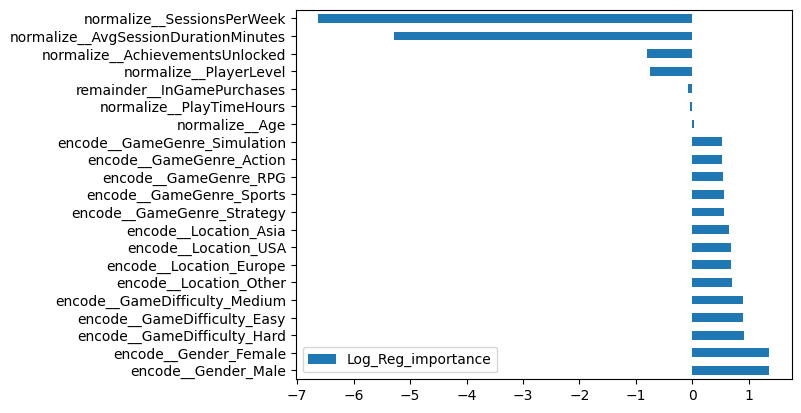

In [ ]:
df_feature_importance_logreg.plot(kind='barh')

In [ ]:
#Probamos con la selección de features por eliminación de forma recursiva:

rfe_model = LogisticRegression(class_weight='balanced', random_state=42)
rfe = RFE(rfe_model, n_features_to_select= 7) #seleccionamos el número de features cuyos pesos en valor absoluto se encuentran mas cercanos a 1
rfe.fit(X_train_prep, y_train_encoded) #entrenamos con el datagrame preprocesado

features_RFE = list(rfe.get_feature_names_out())
features_RFE

['normalize__SessionsPerWeek',
 'normalize__AvgSessionDurationMinutes',
 'encode__Gender_Female',
 'encode__Gender_Male',
 'encode__GameDifficulty_Easy',
 'encode__GameDifficulty_Hard',
 'encode__GameDifficulty_Medium']

#### **Optimización de hiperparámetros y entrenamiento**  

Buscaremos la mejor combinación de hiperparámetros con GridSearch.

In [ ]:
param_grid_log_reg = {
    'modelo__penalty':['l1', 'l2', None], #probaremos con penalización para regular los pesos que le otorga el modelo a las features
    'modelo__C': [1.0, 0.5, 0.2],
    'modelo__class_weight' :['balanced', None],
    'modelo__solver' : ['saga'], #recomendado en la documentacion para problemas multiclase según el tipo de penalización
    'modelo__max_iter' : [50, 100, 150]
}

grid_search_log_reg = GridSearchCV(logreg_pipe, param_grid_log_reg, scoring='balanced_accuracy', cv=stratified_kfold, n_jobs=-1)
grid_search_log_reg.fit(X_train, y_train_encoded) #ya que hemos aplicado penalización, entrenaremos con todo el conjunto de features

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('normalize',
                                                                         Pipeline(steps=[('mmscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'PlayTimeHours',
                                                                          'SessionsPerWeek',
                                                                          'AvgSessionDurationMinutes',
                                                                          'PlayerLevel',
                                                                          'AchievementsUnlocked']),
                                                                        ('encode...
                                                                                          OneHotEncoder(sparse_output=False))]),
                                                                         ['Gender',
                                                                          'Location',
                                                                          'GameGenre',
                                                                          'GameDifficulty'])])),
                                       ('modelo',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__C': [1.0, 0.5, 0.2],
                         'modelo__class_weight': ['balanced', None],
                         'modelo__max_iter': [50, 100, 150],
                         'modelo__penalty': ['l1', 'l2', None],
                         'modelo__solver': ['saga']},
             scoring='balanced_accuracy')

In [137]:
with open('./model/Modelo_Logistic_regression', 'wb') as file:
    pickle.dump(grid_search_log_reg, file)

In [89]:
with open('./model/Modelo_Logistic_regression', 'rb') as file:
    unpickle_model_lr = pickle.load(file)

In [62]:
print('Mejores parámetros:', grid_search_log_reg.best_params_)
print('Mejor score:', grid_search_log_reg.best_score_)

Mejores parámetros: {'modelo__C': 1.0, 'modelo__class_weight': 'balanced', 'modelo__max_iter': 50, 'modelo__penalty': None, 'modelo__solver': 'saga'}
Mejor score: 0.8095509792168574


In [117]:
inicio = time()
unpickle_model_lr.best_estimator_.fit(X_train, y_train_encoded)
tiempo_rl = time() - inicio

In [118]:
tiempo_rl

0.4530203342437744

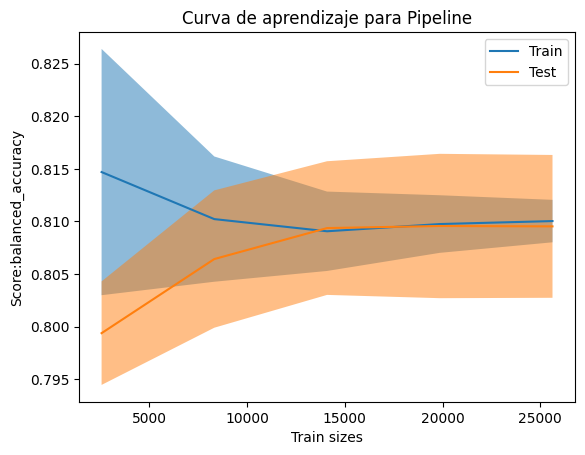

In [73]:
scoring='balanced_accuracy'
plot_learning_curve(grid_search_log_reg.best_estimator_, X_train, y_train_encoded, cv=stratified_kfold, scoring=scoring)

#### **Evaluación contra test**

In [90]:
y_pred_logreg= unpickle_model_lr.predict(X_test) #no usamos el set de test preprocesado porque ya se encarga el pipeline
prediccion_lg = balanced_accuracy_score(y_test_encoded, y_pred_logreg)
test_score_lg = classification_report(y_test_encoded, y_pred_logreg)

print('Balanced Accuracy Score =', prediccion_lg)
print('Predicciones:')
print(classification_report(y_test_encoded, y_pred_logreg, target_names=clases))

Balanced Accuracy Score = 0.8079554218735749
Predicciones:
              precision    recall  f1-score   support

         Low       0.68      0.81      0.74      2065
      Medium       0.87      0.71      0.78      3875
        High       0.79      0.90      0.84      2067

    accuracy                           0.79      8007
   macro avg       0.78      0.81      0.79      8007
weighted avg       0.80      0.79      0.79      8007



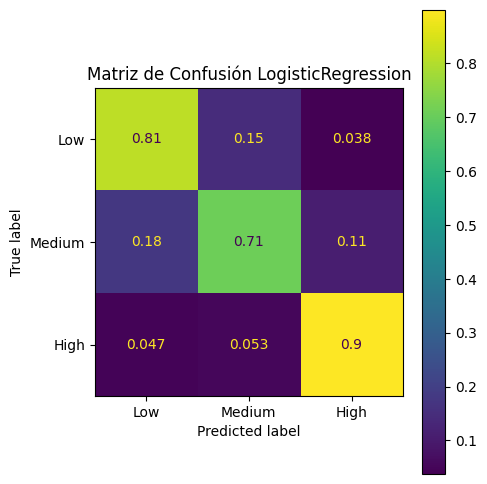

In [91]:
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_logreg, normalize= 'true', ax=ax)
plt.title('Matriz de Confusión LogisticRegression')
plt.xticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.yticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.tight_layout()
plt.show()

In [119]:
#Comprobamos con respecto al baseline
train_baseline_rl = df_resultados_cv.loc['LogisticRegression']['train_score']
train_rl = unpickle_model_lr.best_score_
test_baseline_rl = df_resultados_cv.loc['LogisticRegression']['val_score']
time_baseline_rl = df_resultados_cv.loc['LogisticRegression']['fit_time']

df_comp_lr = pd.DataFrame({'train_score': [train_baseline_rl, train_rl],
                           'fit_time': [time_baseline_rl, tiempo_rl],
              'test_score' : [test_baseline_rl, prediccion_lg]}, index= ['Log_reg_Baseline', 'Log_reg_model'])
df_comp_lr

train_score  fit_time  test_score
Log_reg_Baseline     0.806924  0.240533    0.805952
Log_reg_model        0.809551  0.453020    0.807955

**Conclusiones**  
En cuanto a la curva de aprendizaje, el modelo sigue presentando mucha variabilidad tanto en train como en validación. Aunque la curva de train en el modelo optimizado no presenta un descenso drástico, llega a converger con la de validación. Otro punto de interés es que a pesar de haber añadido opciones de penalización en GridSearch para eliminar features con coeficientes más bajos y reducir la posibilidad de ruido, el modelo tiene mejor score sin aplicarla.

Si analizamos la matriz de confusión observamos:  
- Predice mejor las clases minoritarias, en concreto 'High' es en la que menos error comente.
- Donde más confusión se genera es entre la clase 'Low' y 'Medium'.  

### **2. RandomForestClassifier**

#### **Feature Importance**
Recurriremos al propio modelo para determinar las features más importantes y acotar la información que le llega al modelo.

In [25]:
#Mantenemos el preprocesado para que esté en igualdad de condiciones con el baseline
random_forest = Pipeline([
    ('preprocessing', preprocessing),
    ('modelo', RandomForestClassifier(random_state=42))
])

random_forest.fit(X_train, y_train_encoded)

df_features_importance_rf = pd.DataFrame(random_forest[1].feature_importances_, columns= ['importance']).set_index(X_train_prep.columns) #Accedemos al segundo elemento del pipeline
df_features_importance_rf = df_features_importance_rf.sort_values(by= 'importance', ascending=False)
df_features_importance_rf

importance
normalize__SessionsPerWeek              0.391576
normalize__AvgSessionDurationMinutes    0.278921
normalize__PlayTimeHours                0.064541
normalize__PlayerLevel                  0.061302
normalize__AchievementsUnlocked         0.057922
normalize__Age                          0.049844
remainder__InGamePurchases              0.008104
encode__Location_USA                    0.007432
encode__Location_Europe                 0.007111
encode__GameDifficulty_Easy             0.006875
encode__GameDifficulty_Medium           0.006490
encode__GameGenre_Action                0.006444
encode__GameGenre_Sports                0.006398
encode__GameGenre_Strategy              0.006371
encode__GameGenre_Simulation            0.006294
encode__Location_Asia                   0.006291
encode__Gender_Female                   0.005995
encode__Gender_Male                     0.005976
encode__GameGenre_RPG                   0.005819
encode__GameDifficulty_Hard             0.005641
encode__Location_Other                  0.004653

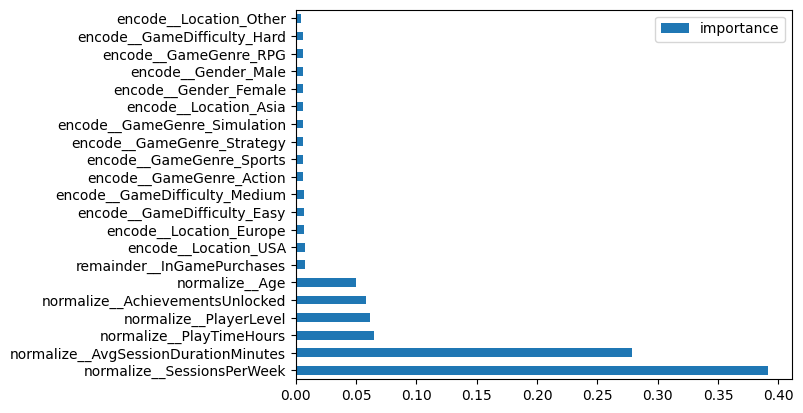

In [ ]:
df_features_importance_rf.plot(kind='barh');

#### **Optimización de Hiperparámetros**


In [82]:
model_pipe_rf = ImbPipeline([#no le ponemos preprocesado porque entrenaremos con X_train_prep para poder filtrar por las columnas seleccionadas por el feature importance
                          ('sampling', None), #aquí emplearemos el GridSearch para determinar cuál será el mejor método de muestreo
                          ('modelo', RandomForestClassifier(random_state=42))
                          ])


param_grid_rf = {
    'sampling' : [RandomOverSampler(random_state=42), None],
    'modelo__n_estimators': [50, 100, 150],
    'modelo__max_depth': [10, 20, 30, None],
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [1, 2, 4],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__bootstrap' : [True, False],
    'modelo__class_weight': ['balanced', None] #Para tener alternativas con el sampling
}

In [ ]:
grid_search_rf = GridSearchCV(model_pipe_rf, param_grid=param_grid_rf, scoring='balanced_accuracy', cv=stratified_kfold, n_jobs=-1)
grid_search_rf.fit(X_train_prep[features_selected], y_train_encoded) #usamos la misma lista de feature importance que en LGBM

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling', None),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__bootstrap': [True, False],
                         'modelo__class_weight': ['balanced', None],
                         'modelo__max_depth': [10, 20, 30, None],
                         'modelo__max_features': ['sqrt', 'log2'],
                         'modelo__min_samples_leaf': [1, 2, 4],
                         'modelo__min_samples_split': [2, 5, 10],
                         'modelo__n_estimators': [50, 100, 150],
                         'sampling': [RandomOverSampler(random_state=42),
                                      None]},
             scoring='balanced_accuracy')

In [ ]:
with open ('Modelo_RandomForestClas_RandomOverSampler', 'wb') as file:
    pickle.dump(grid_search_rf, file)

In [26]:
with open ('./model/Modelo_RandomForestClas_RandomOverSampler', 'rb') as file:
    unpickle_model_rf= pickle.load(file)

In [99]:
print('Mejores parámetros:', unpickle_model_rf.best_params_)
print('Mejor score:', unpickle_model_rf.best_score_)

Mejores parámetros: {'modelo__bootstrap': True, 'modelo__class_weight': 'balanced', 'modelo__max_depth': 20, 'modelo__max_features': 'sqrt', 'modelo__min_samples_leaf': 1, 'modelo__min_samples_split': 2, 'modelo__n_estimators': 150, 'sampling': RandomOverSampler(random_state=42)}
Mejor score: 0.910094212181382


In [31]:
inicio = time()
unpickle_model_rf.best_estimator_.fit(X_train_prep[features_selected], y_train_encoded)
tiempo_rf = time() - inicio

In [32]:
tiempo_rf

13.543649196624756

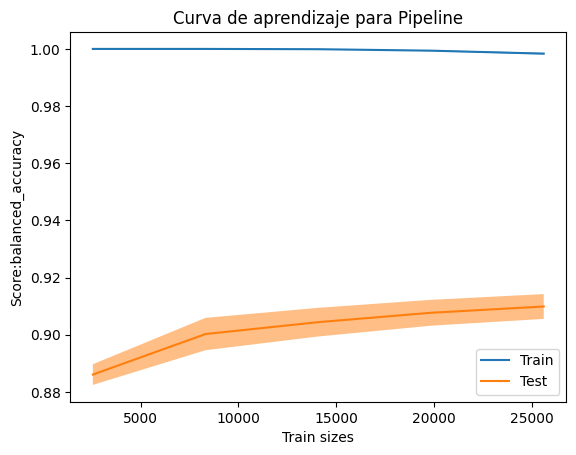

In [92]:
plot_learning_curve(unpickle_model_rf.best_estimator_, X_train_prep[features_selected], y_train_encoded,
                    cv=stratified_kfold, scoring= 'balanced_accuracy')

#### **Control de Overfitting en RandomForestClassifier**
Vamos a probar lo siguiente para controlar el overfitting que sufre el modelo:
- Reducir el número de árboles y la profundidad 
- Prescindir de técnicas de muestreo (RandomOverSampler()), recurriremos sólo al hiperparámetro del propio modelo ```class_weight``` para el balanceo de clases
- Entrenaremos sin redudcción de features

In [ ]:
model_pipe_rf_bis = Pipeline([('preprocesado', preprocessing), #entrenaremos con todas las features
                          ('modelo', RandomForestClassifier(random_state=42))
                          ])

param_grid_rf_bis = {
    'modelo__n_estimators': [10, 20, 50], #10 ,20, 50 --> con 50 árboles no mejora a 10, 20
    'modelo__max_depth': [2, 5, 8], #probamos a incluir 8 en profundidad
    'modelo__min_samples_split': [5, 10],
    'modelo__min_samples_leaf': [2, 4],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__bootstrap' : [True, False],
    'modelo__class_weight': ['balanced', None]} #Para tener alternativas con el sampling

In [58]:
grid_search_rf_restricted = GridSearchCV(model_pipe_rf_bis, param_grid=param_grid_rf_bis, scoring='balanced_accuracy',
                                         cv=stratified_kfold, n_jobs=-1, return_train_score=True) #para comparar luego en un dataframe 
grid_search_rf_restricted.fit(X_train, y_train_encoded)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('normalize',
                                                                         Pipeline(steps=[('mmscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'PlayTimeHours',
                                                                          'SessionsPerWeek',
                                                                          'AvgSessionDurationMinutes',
                                                                          'PlayerLevel',
                                                                          'AchievementsUnlocked']),
                                                                        ('encode'...
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__bootstrap': [True, False],
                         'modelo__class_weight': ['balanced', None],
                         'modelo__max_depth': [2, 5, 8],
                         'modelo__max_features': ['sqrt', 'log2'],
                         'modelo__min_samples_leaf': [2, 4],
                         'modelo__min_samples_split': [5, 10],
                         'modelo__n_estimators': [10, 20, 50]},
             return_train_score=True, scoring='balanced_accuracy')

In [72]:
with open ('./model/Modelo_RandomForestClas_control_1', 'wb') as file:
    pickle.dump(grid_search_rf_restricted, file)

In [71]:
df_results_gs = pd.DataFrame(grid_search_rf_restricted.cv_results_)
df_results_gs[['mean_train_score', 'mean_test_score']].sort_values(by='mean_train_score', ascending=False)

mean_train_score  mean_test_score
56           0.873347         0.859316
68           0.873347         0.859316
50           0.871850         0.859451
62           0.871850         0.859451
203          0.871049         0.857463
..                ...              ...
234          0.391939         0.391304
216          0.391939         0.391304
231          0.391939         0.391304
228          0.391939         0.391304
225          0.391939         0.391304

[288 rows x 2 columns]

In [59]:
print('Mejores parámetros:', grid_search_rf_restricted.best_params_)
print('Mejor score:', grid_search_rf_restricted.best_score_)

Mejores parámetros: {'modelo__bootstrap': True, 'modelo__class_weight': 'balanced', 'modelo__max_depth': 8, 'modelo__max_features': 'sqrt', 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 50}
Mejor score: 0.8594507563568555


In [73]:
inicio = time()
grid_search_rf_restricted.best_estimator_.fit(X_train, y_train_encoded)
tiempo_rf_rest = time() - inicio
tiempo_rf_rest

1.5373499393463135

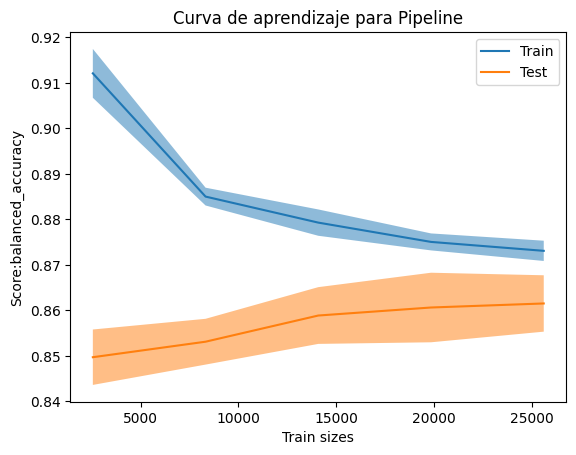

In [60]:
plot_learning_curve(grid_search_rf_restricted.best_estimator_, X_train, y_train_encoded,
                    cv=stratified_kfold, scoring= 'balanced_accuracy')

Probaremos a afinar un poco más por si podemos conseguir mejores métricas sin llegar al overfitting:

In [74]:
model_pipe_rf_control_2 = Pipeline([('preprocesado', preprocessing), #entrenaremos con todas las features
                          ('modelo', RandomForestClassifier(random_state=42))
                          ])

param_grid_rf_c2 = {
    'modelo__n_estimators': [10, 20, 50, 80], #10 ,20, 50 --> con 50 árboles no mejora a 10, 20
    'modelo__max_depth': [2, 5, 8, 12],
    'modelo__min_samples_split': [5, 10],
    'modelo__min_samples_leaf': [2, 4],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__bootstrap' : [True, False],
    'modelo__class_weight': ['balanced', None]}

grid_search_rf_control_2 = GridSearchCV(model_pipe_rf_control_2, param_grid=param_grid_rf_c2, scoring='balanced_accuracy',
                                         cv=stratified_kfold, n_jobs=-1, return_train_score=True) #para comparar luego en un dataframe 
grid_search_rf_control_2.fit(X_train, y_train_encoded)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('normalize',
                                                                         Pipeline(steps=[('mmscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'PlayTimeHours',
                                                                          'SessionsPerWeek',
                                                                          'AvgSessionDurationMinutes',
                                                                          'PlayerLevel',
                                                                          'AchievementsUnlocked']),
                                                                        ('encode'...
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__bootstrap': [True, False],
                         'modelo__class_weight': ['balanced', None],
                         'modelo__max_depth': [2, 5, 8, 12],
                         'modelo__max_features': ['sqrt', 'log2'],
                         'modelo__min_samples_leaf': [2, 4],
                         'modelo__min_samples_split': [5, 10],
                         'modelo__n_estimators': [10, 20, 50, 80]},
             return_train_score=True, scoring='balanced_accuracy')

In [79]:
with open ('./model/Modelo_RandomForestClas_control_2', 'wb') as file:
    pickle.dump(grid_search_rf_control_2, file)

In [75]:
df_results_gs_2 = pd.DataFrame(grid_search_rf_control_2.cv_results_)
df_results_gs_2[['mean_train_score', 'mean_test_score']].sort_values(by='mean_train_score', ascending=False)

mean_train_score  mean_test_score
355          0.925244         0.886020
371          0.925244         0.886020
370          0.924782         0.883893
354          0.924782         0.883893
369          0.922920         0.879665
..                ...              ...
396          0.391939         0.391304
392          0.391939         0.391304
412          0.391939         0.391304
384          0.391939         0.391304
388          0.391939         0.391304

[512 rows x 2 columns]

In [76]:
print('Mejores parámetros:', grid_search_rf_control_2.best_params_)
print('Mejor score:', grid_search_rf_control_2.best_score_)

Mejores parámetros: {'modelo__bootstrap': False, 'modelo__class_weight': 'balanced', 'modelo__max_depth': 12, 'modelo__max_features': 'sqrt', 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 80}
Mejor score: 0.8860198768572882


In [ ]:
inicio = time()
grid_search_rf_control_2.best_estimator_.fit(X_train, y_train_encoded)
tiempo_rf_c2 = time() - inicio
tiempo_rf_c2

4.703168153762817

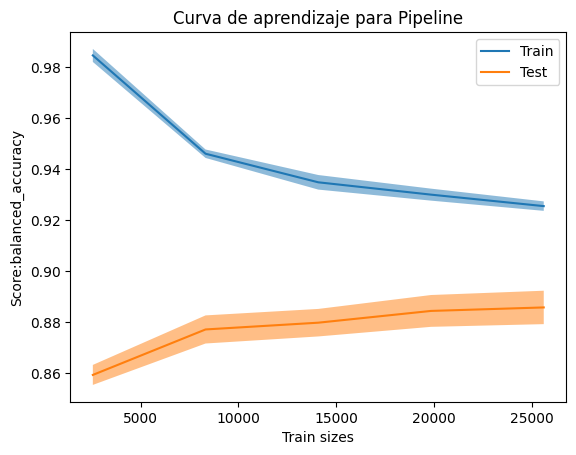

In [78]:
plot_learning_curve(grid_search_rf_control_2.best_estimator_, X_train, y_train_encoded,
                    cv=stratified_kfold, scoring= 'balanced_accuracy')

##### **Conclusiones sobre el manejo de overfitting en RandomForestClassifier**
Después del baseline que presentaba overfitting, hemos optimizado 3 modelos:  

- En la primera optimización, empleo RandomOverSampler como técnica de muestreo, estructurando un grid con cierta profundidad de árboles y nodos además de entrenar el modelo sólo con aquellas variables de mayor peso. Sin embargo, no hemos conseguido que generalice mejor y el tiempo de ejecución durante el entrenamiento del GridSearch ha sido bastante largo en comparación con otros.  

- En la segunda optimización, el objetivo es 'dificultar' el aprendizaje. Pruebo a eliminar el sampling y que el modelo balancee las clases sólo tomando el hiperparámetro class_weight, lo que ha mejorado notablemente el rendimiento del entrenamiento. Por otro lado, hemos restringido drásticamente la profundidad de árboles y sus nodos además de entrenarlo con todas las variables. De esta forma sí hemos logrado conseguir que el modelo no tienda al sobreajuste a pesar de bajar sus métricas de predicción.   

- En la tercera optimización, el objetivo ha sido comprobar si añadiendo profundidad y nodos, podemos mejorar las métricas anteriores o el modelo comienza a sobreajustarse. En este caso, a partir de 50 árboles el modelo comienza a presentar sobreajuste como hemos podido comprobar en las curvas de aprendizaje. 

Por tanto, nos quedaremos con la segunda optimización como mejor opción para RandomForestClassifier.

#### **Evaluacion contra test: modelo optimizado**
Evaluamos el modelo seleccionado


In [82]:
y_pred_rf= grid_search_rf_restricted.predict(X_test) #hemos entrenado con pipeline, pasamos el conjunto original para que lo precese el pipeline
prediccion_rf = balanced_accuracy_score(y_test_encoded, y_pred_rf)
test_score_rf = classification_report(y_test_encoded, y_pred_rf)

print('Balanced Accuracy Score =', prediccion_rf)
print('Predicciones:')
print(classification_report(y_test_encoded, y_pred_rf, target_names=clases))

Balanced Accuracy Score = 0.8516418993124483
Predicciones:
              precision    recall  f1-score   support

         Low       0.82      0.88      0.85      2065
      Medium       0.89      0.82      0.85      3875
        High       0.80      0.86      0.83      2067

    accuracy                           0.84      8007
   macro avg       0.84      0.85      0.84      8007
weighted avg       0.85      0.84      0.84      8007



In [83]:
df_resultados_cv = pd.read_csv('./data/df_resultados_cv.csv', index_col=0)

In [86]:
train_baseline_rf = df_resultados_cv.loc['RandomForestClas']['train_score']
train_rf = grid_search_rf_restricted.best_score_
test_baseline_rf = df_resultados_cv.loc['RandomForestClas']['val_score']
time_baseline_rf = df_resultados_cv.loc['RandomForestClas']['fit_time']

df_comp_rf = pd.DataFrame({'train_score': [train_baseline_rf, train_rf],
                           'fit_time' : [time_baseline_rf, tiempo_rf_rest],
              'test_score' : [test_baseline_rf, prediccion_rf]}, index= ['RandomForest_Baseline', 'RandomForest_model'])
df_comp_rf

train_score  fit_time  test_score
RandomForest_Baseline     0.999995  4.943788    0.881759
RandomForest_model        0.859451  1.537350    0.851642

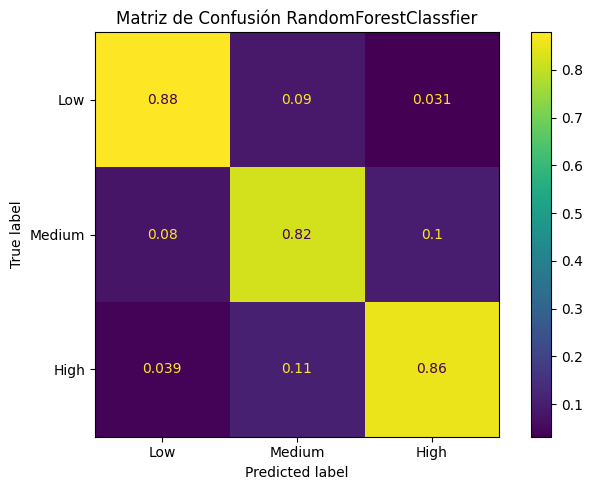

In [88]:
fig, ax = plt.subplots(figsize=(7,5))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_rf, normalize= 'true', ax=ax)
plt.title('Matriz de Confusión RandomForestClassfier')
plt.xticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.yticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.tight_layout()
plt.show()

**Conclusiones**  
El control del sobreajuste afecta a la calidad de las predicciones, aunque siguen siendo bastante buenas. Dentro del ranking de modelos, estaría en el segundo puesto tras LGBMClassifier y por encima de LogisticRegressor.

Si analizamos la matriz de confusión observamos:  
- Predice mejor las clases minoritarias, podemos deducir que se debe a los pesos que se han otorgado durante la etapa de balanceo.
- A su vez, confunde en mayor medida 'Medium' y 'High' 

### **3. Red Neuronal Simple (MLP)**

Probaremos a diseñar una red neuronal simple para comparar métricas y tiempos de ejecución con el resto de modelos. El objetivo es controlar el overfitting y comprobar si se optimizan los tiempos de ejecución con respecto a los modelos que más gasto computacional requieren.  

Comenzaremos con el diseño de una red simple, sin recurrir a la optimización con GridSearch.

#### Preprocesado

In [30]:
#Aplicamos transformaciones al dataset de train ya que anteriormente sólo hemos aplicado fit() para no contaminar la validación cruzada
X_train_dl = preprocessing.fit_transform(X_train)
X_test_dl = preprocessing.transform(X_test)

In [31]:
X_train_dl.head(3)

normalize__Age  normalize__PlayTimeHours  normalize__SessionsPerWeek  \
13686        0.882353                  0.644979                    0.526316   
37598        0.264706                  0.683431                    0.263158   
37339        0.882353                  0.830031                    0.315789   

       normalize__AvgSessionDurationMinutes  normalize__PlayerLevel  \
13686                              0.579882                0.867347   
37598                              0.396450                0.561224   
37339                              0.153846                0.030612   

       normalize__AchievementsUnlocked  encode__Gender_Female  \
13686                         0.387755                    0.0   
37598                         0.469388                    1.0   
37339                         0.469388                    0.0   

       encode__Gender_Male  encode__Location_Asia  encode__Location_Europe  \
13686                  1.0                    0.0                      1.0   
37598                  0.0                    0.0                      1.0   
37339                  1.0                    0.0                      0.0   

       ...  encode__Location_USA  encode__GameGenre_Action  \
13686  ...                   0.0                       0.0   
37598  ...                   0.0                       0.0   
37339  ...                   1.0                       0.0   

       encode__GameGenre_RPG  encode__GameGenre_Simulation  \
13686                    0.0                           0.0   
37598                    0.0                           0.0   
37339                    0.0                           1.0   

       encode__GameGenre_Sports  encode__GameGenre_Strategy  \
13686                       0.0                         1.0   
37598                       0.0                         1.0   
37339                       0.0                         0.0   

       encode__GameDifficulty_Easy  encode__GameDifficulty_Hard  \
13686                          1.0                          0.0   
37598                          1.0                          0.0   
37339                          0.0                          0.0   

       encode__GameDifficulty_Medium  remainder__InGamePurchases  
13686                            0.0                           1  
37598                            0.0                           0  
37339                            1.0                           1  

[3 rows x 21 columns]

In [32]:
X_train_dl.shape

(32027, 21)

#### Balanceo de clases

In [ ]:
#para balancear las clases probaremos con compute_class_weight
class_weight_dl = compute_class_weight(class_weight='balanced', 
                                       classes= np.unique(y_train_encoded), y= y_train_encoded) #pasamos el dataset ya codificado anteriormente

#la salida de la función será un array con los pesos, generaremos un diccionario con el resultado  de cada clase para visualizarlo.
class_weight_dl_dic = dict(zip(np.unique(y_train_encoded), class_weight_dl))
class_weight_dl_dic

{0: 1.292610081930823, 1: 0.688797126696346, 2: 1.291046881928488}

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
#Teniendo ya los pesos que otorga la función automaticamente a casa clase, los imputamos al todo el set de y_train

sample_w = compute_sample_weight(class_weight=class_weight_dl_dic, y= y_train_dl_subset )
sample_w

array([1.29104688, 0.68879713, 1.29104688, ..., 0.68879713, 0.68879713,
       1.29104688])

#### Arquitectura simple

In [33]:
modelo_1 = keras.Sequential()
modelo_1.add(keras.Input(shape=(X_train_dl.shape[1],))) #añadimos todas las features del set de train
modelo_1.add(keras.layers.Dense(50, activation='relu'))
modelo_1.add(keras.layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')) #capa de salida con 3 salidas, una por cada clase

In [34]:
optimizador = keras.optimizers.Adam(learning_rate=0.001) #probamos con el valor por defecto

In [38]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='modelo_1_best.keras', save_best_only=True, monitor='val_loss', verbose=0)

In [39]:
modelo_1.compile(optimizer=optimizador, loss='sparse_categorical_crossentropy', #vamos a pasarle numeros enteros en y
                 metrics=['accuracy'])

In [106]:
modelo_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,761 (14.70 KB)

 Trainable params: 1,253 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,508 (9.80 KB)

#### Entrenamiento

In [ ]:
#Generamos un set de validación de forma manual para asegurarnos de que habrá la misma proporción de clases en validación
X_train_dl_subset, X_val_dl_subset, y_train_dl_subset, y_val_dl_subset = train_test_split(X_train_dl, y_train_encoded, 
                                                                                          test_size=0.2, stratify=y_train_encoded)
print(X_train_dl_subset.shape, y_train_dl_subset.shape)
print(X_val_dl_subset.shape, y_val_dl_subset.shape)

(25621, 21) (25621,)
(6406, 21) (6406,)


In [55]:
inicio = time()

history = modelo_1.fit(X_train_dl_subset, y_train_dl_subset, batch_size=64, epochs=50,
                       sample_weight= sample_w, 
                       validation_data=(X_val_dl_subset, y_val_dl_subset), verbose=1,
                        callbacks=[early_stopping, checkpoint] )

fit_time_modelo_1 = time() - inicio

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4676 - loss: 1.0040 - val_accuracy: 0.6761 - val_loss: 0.7241
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7463 - loss: 0.6350 - val_accuracy: 0.7772 - val_loss: 0.6296
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7854 - loss: 0.6053 - val_accuracy: 0.7927 - val_loss: 0.6067
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8093 - loss: 0.5852 - val_accuracy: 0.7944 - val_loss: 0.5977
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8176 - loss: 0.5687 - val_accuracy: 0.8272 - val_loss: 0.5687
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8301 - loss: 0.5511 - val_accuracy: 0.8583 - val_loss: 0.5302
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8501 - loss: 0.5255 - val_accuracy: 0.8473 - val_loss: 0.5284
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8610 - loss: 0.5135 - val_accuracy: 0.

In [56]:
fit_time_modelo_1

35.306530475616455

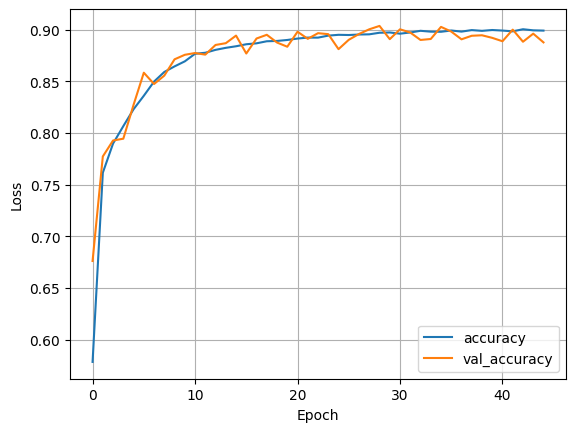

In [57]:
df_history_modelo_1 = pd.DataFrame(history.history)
df_history_modelo_1[['accuracy', 'val_accuracy']].plot()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch");

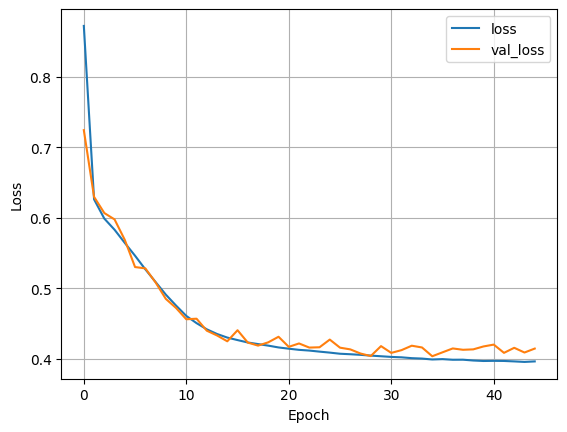

In [58]:
df_history_modelo_1 = pd.DataFrame(history.history)
df_history_modelo_1[['loss', 'val_loss']].plot()
plt.grid(True)
plt.ylabel("Loss")
plt.xlabel("Epoch");

#### **Evaluación y predicciones**

In [62]:
modelo_1.evaluate(X_test_dl, y_test_encoded)

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8930 - loss: 0.4445


[0.41759786009788513, 0.8987136483192444]

In [63]:
y_pred_modelo_1 = [np.argmax(prediccion) for prediccion in modelo_1.predict(X_test_dl)]

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [64]:
print(classification_report(y_test_encoded, y_pred_modelo_1, target_names=clases))

              precision    recall  f1-score   support

         Low       0.86      0.90      0.88      2065
      Medium       0.91      0.91      0.91      3875
        High       0.91      0.88      0.89      2067

    accuracy                           0.90      8007
   macro avg       0.90      0.89      0.89      8007
weighted avg       0.90      0.90      0.90      8007



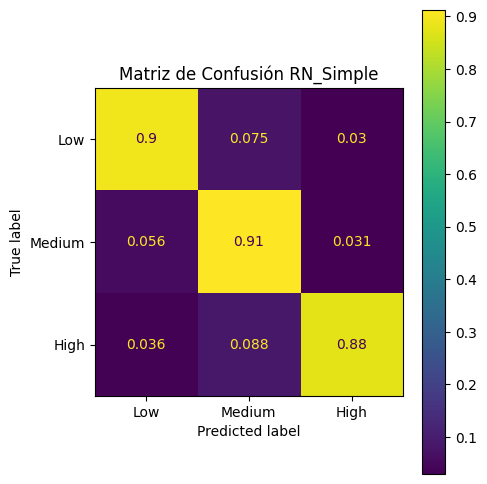

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_modelo_1, normalize= 'true', ax=ax)
plt.title('Matriz de Confusión RN_Simple')
plt.xticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.yticks(ticks=[0,1,2], labels=['Low', 'Medium', 'High'])
plt.tight_layout()
plt.show()

**Conclusiones**  
Una red neuronal simple es capaz de realizar muy buenas predicciones sin tender al sobreajuste ni necesitar optimización para este problema de clasificación en concreto. Además el tiempo de entrenamiento es considerablemente menor al que requieren los modelos basados en árboles.

Si analizamos la matriz de confusión observamos:
- La proporción de acierto es muy similar al LGBMClassfier. Ha sabido ajustar bien los pesos de las clases minoritarias para realizar predicciones.
- El margen de error entre clases es mínimo, aunque la clase donde mayor índice de error presenta es 'Medium'.


A continuación veremos una comparativa de métricas y tiempos de entrenamiento sobre los modelos optimizados:


In [123]:
score_dl = modelo_1.evaluate(X_test_dl, y_test_encoded)
val_score_dl = score_dl[1]
test_score = balanced_accuracy_score(y_test_encoded, y_pred_modelo_1)

df_comp_modelo_1 = pd.DataFrame({'val_socre' : val_score_dl,
                                 'test_score' : test_score,
                                 'fit_time': fit_time_modelo_1}, index=['RNSimple'])

df_comp_modelo_1

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.8994 - loss: 0.4287


val_socre  test_score   fit_time
RNSimple   0.905583    0.894293  42.736553

In [122]:
df_comparativa = pd.concat([df_comp_lgbm, df_comp_lr, df_comp_rf])
df_comparativa.filter(regex='_model$', axis=0)

train_score  fit_time  test_score
LGBM_model             0.903829  0.398759    0.898335
Log_reg_model          0.809551  0.453020    0.807955
RandomForest_model     0.859451  1.537350    0.851642